# 1. Database Integration
  -> Store in DB in long format rather than wide format in case data is added in the future
## 1.1 connect with Neon (DB) - .env Load
  -> Create new file ".env"  
  -> Copy the psql code from Neon Connect  
  -> Paste "DATABASE_URL=postgresql://~" into the .env file and save it.  
  -> If connected normally, "True" is displayed

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()  # Automatically load .env in the same folder
dsn = os.getenv("DATABASE_URL")
print("DATABASE_URL loaded:", bool(dsn))  # Print True/False

DATABASE_URL loaded: True


## 1.2 Set CSV path & check

In [2]:
from pathlib import Path

BASE = Path.cwd()
CSV_PATH = Path("data/RMBR4-2_export_test.csv")  # Use the own path
assert CSV_PATH.exists(), "The CSV file is not in the path. Check the path."
print("CSV:", CSV_PATH)

CSV: data\RMBR4-2_export_test.csv


## 1.3 Load original CSV (automatically attempts encoding)  
- Prevents errors and values ​​resulting in NaN/broken strings due to incorrect encoding  
-> Read the entire CSV with the first successful encoding and save it to df_raw  
-> Try pd.read.csv in the order "utf-8 > utf-8-sig > cp949 > euc-kr > latin1"  
-> If all encodings fail, try again with engine="python".

In [3]:
import pandas as pd

df_raw = None
enc_used = None
for enc in ["utf-8","utf-8-sig","cp949","euc-kr","latin1"]:
    try:
        df_raw = pd.read_csv(CSV_PATH, encoding=enc)
        enc_used = enc
        break
    except Exception:
        pass
if df_raw is None:
    df_raw = pd.read_csv(CSV_PATH, engine="python")
    enc_used = "auto(engine=python)"

print("encoding:", enc_used, "| shape:", df_raw.shape)
display(df_raw.head(3))

encoding: utf-8 | shape: (39672, 16)


,Trait,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8,Axis #9,Axis #10,Axis #11,Axis #12,Axis #13,Axis #14,Time
0,current,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-17T12:18:23.660Z
1,current,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-17T12:18:25.472Z
2,current,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-17T12:18:27.348Z


# 1.4 Convert "Time" → "Seconds"(real number)  
 -> Parse character/date formats as 'datetime' first  
 -> Unparsable values ​​are treated as NaT (missing)  
 -> If parsing is successful, normalize the “first time” to 0 seconds  
 -> 'time_s' indicates "how many seconds have passed since the first hour" of each row  
 -> If parsing fails (if stored as numeric text only), convert after cleaning up the number
#### Result 
- time_s non-null ratio output:   
 -> If 1.0, all rows are converted successfully (no missing data)  
 -> If it's around 0.95, 5% of the rows are parsed incorrectly (missing data)

In [4]:
import pandas as pd
import numpy as np

assert "Time" in df_raw.columns, "no 'Time' column in the CSV."

t_dt = pd.to_datetime(df_raw["Time"], errors="coerce", utc=False)

if t_dt.notna().sum() > 0:
    t0 = t_dt.dropna().iloc[0]
    time_s = (t_dt - t0).dt.total_seconds()
else:
    s = df_raw["Time"].astype(str).str.strip()
    s = s.str.replace(r"[^\d,.\-+eE]", "", regex=True)                 # Numbers/Signs/Exponents/Separators Only
    s = s.str.replace(r"(?<=\d),(?=\d{3}(\D|$))", "", regex=True)      # Remove thousands commas
    s = s.str.replace(",", ".", regex=False)                           # Replace decimal commas with periods
    time_s = pd.to_numeric(s, errors="coerce")

print("time_s non-null ratio:", time_s.notna().mean())

time_s non-null ratio: 1.0


# 1.5 Axis (#1~#8) Numbering & Interpolation
- Continuous signals required for regression, residual, and threshold detection are secured  
- The streaming simulator inserts every record into the database without exception  
-> To maintain a continuous time series, fill in the NaN intervals by connecting the previous and next valid values ​​with a straight line.

#### Result  
- on-null ratio for each column: 1.0 - No missing Data  
- After interpolation shape: 0.0 - Since both ends of the actual data remain 0, 0 is maintained in the interpolation of both ends  
- 'time' displays the number of seconds increased from the initial value  

In [5]:
import re
import pandas as pd
import numpy as np

# If there is a default axis name, use that.
default_axes = [f"Axis #{i}" for i in range(1, 9)]
present_defaults = [c for c in default_axes if c in df_raw.columns]

if present_defaults:
    axes_cols = present_defaults
else:
    # fallback: Automatically detect numeric candidates
    numeric_like = []
    for c in df_raw.columns:
        lc = str(c).lower().strip()
        if re.search(r"(axis|axes)\s*#?\s*(\d+)", lc) or re.match(r"^ch(annel)?\s*\d+", lc):
            numeric_like.append(c)
    axes_cols = numeric_like[:8]
    assert axes_cols, "Could not find the axis column. Provide the column name"

def clean_numeric_series(ser: pd.Series) -> pd.Series:
    s = ser.astype(str).str.strip()
    s = s.str.replace(r"[^\d,.\-+eE]", "", regex=True)                 # Numbers/Signs/Exponents/Separators Only
    s = s.str.replace(r"(?<=\d),(?=\d{3}(\D|$))", "", regex=True)      # Remove thousands commas
    s = s.str.replace(",", ".", regex=False)                           # Replace decimal commas with periods
    return pd.to_numeric(s, errors="coerce")

df_num = pd.DataFrame({"time_s": time_s})
for c in axes_cols:
    df_num[c] = clean_numeric_series(df_raw[c])

print("Non-null ratio for each column:")
display(df_num.notna().mean().to_frame("nonnull_ratio").T)

# Time axis NaNs are removed, and the axis is filled with interpolation.
df_filled = df_num.dropna(subset=["time_s"]).copy()
for c in axes_cols:
    df_filled[c] = df_filled[c].interpolate(limit_direction="both")

print("After interpolation shape:", df_filled.shape)
display(df_filled.head(3))

Non-null ratio for each column:


,time_s,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
nonnull_ratio,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


After interpolation shape: (39672, 9)


,time_s,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 1.6 Final DF preparation, setting downstream compatible variables  
-> Steps for integrating interfaces that process data

In [6]:
df_clean = df_filled.dropna(subset=["time_s"] + axes_cols).reset_index(drop=True)

# Unified for cell compatibility
df = df_clean.copy()
time_col = "time_s"

print("df_clean rows:", len(df_clean))
print("time_col:", time_col)
print("axes_cols:", axes_cols)
display(df_clean[[time_col] + axes_cols].head(3))

df_clean rows: 39672
time_col: time_s
axes_cols: ['Axis #1', 'Axis #2', 'Axis #3', 'Axis #4', 'Axis #5', 'Axis #6', 'Axis #7', 'Axis #8']


,time_s,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1.7 Defining the StreamingSimulator class

In [ ]:
import os, sqlite3
import matplotlib.pyplot as plt
from typing import List

class StreamingSimulator:
    def __init__(
        self,
        csv_df,                   
        time_col: str,
        axes_cols: List[str],
        table_name: str = "stream_samples",
        dsn_env: str = "DATABASE_URL",
        plot_axis_index: int = 0             
    ):
        self.df = csv_df
        self.time_col = time_col
        self.axes_cols = axes_cols
        self.table_name = table_name
        self.dsn_env = dsn_env
        self._i = 0

        self._dsn = os.getenv(self.dsn_env, "").strip()
        self._backend = "postgres" if self._dsn else "sqlite"
        self._sqlite_path = str(BASE / "local_demo.db")

        self._fig = None
        self._ax = None
        self._plot_axis_index = int(plot_axis_index) if plot_axis_index is not None else 0
        if not (0 <= self._plot_axis_index < len(self.axes_cols)):
            self._plot_axis_index = 0
        self._x_vals, self._y_vals = [], []

    @property
    def has_next(self) -> bool:
        return self._i < len(self.df)

    def _connect(self):
        if self._backend == "postgres":
            import psycopg2
            conn = psycopg2.connect(self._dsn)
            cur = conn.cursor()
            cur.execute(f"""
                CREATE TABLE IF NOT EXISTS {self.table_name} (
                    ts DOUBLE PRECISION,
                    axis_id INTEGER,
                    value DOUBLE PRECISION
                );
            """)
            conn.commit()
            return conn, cur
        else:
            conn = sqlite3.connect(self._sqlite_path)
            cur = conn.cursor()
            cur.execute(f"""
                CREATE TABLE IF NOT EXISTS {self.table_name} (
                    ts REAL,
                    axis_id INTEGER,
                    value REAL
                );
            """)
            conn.commit()
            return conn, cur

    def nextDataPoint(self):
        """Per record: DB connection → INSERT → plot update → DB termination, and then return a 1-row DataFrame"""
        if not self.has_next:
            raise StopIteration("No more data.")
        row = self.df.iloc[[self._i]]
        ts = float(row[self.time_col].iloc[0])

        # 1) open
        conn, cur = self._connect()

        # 2) insert
        for idx, col in enumerate(self.axes_cols, start=1):
            val = float(row[col].iloc[0])
            if self._backend == "sqlite":
                cur.execute(f"INSERT INTO {self.table_name} (ts, axis_id, value) VALUES (?, ?, ?)", (ts, idx, val))
            else:
                cur.execute(f"INSERT INTO {self.table_name} (ts, axis_id, value) VALUES (%s, %s, %s)", (ts, idx, val))
        conn.commit()

        # 3) plot refresh (selection axis only)
        axis_col = self.axes_cols[self._plot_axis_index]
        y = float(row[axis_col].iloc[0])
        if self._fig is None or self._ax is None:
            self._fig, self._ax = plt.subplots(figsize=(10, 4))
            self._ax.set_title(f"Streaming — {axis_col}")
            self._ax.set_xlabel("time (s)")
            self._ax.set_ylabel("value")
        self._x_vals.append(ts); self._y_vals.append(y)
        self._ax.clear()
        self._ax.set_title(f"Streaming — {axis_col}")
        self._ax.set_xlabel("time (s)")
        self._ax.set_ylabel("value")
        self._ax.plot(self._x_vals, self._y_vals) 
        plt.pause(0.001)

        # 4) close
        cur.close()
        conn.close()

        self._i += 1
        return row[[self.time_col] + self.axes_cols].copy()

    def reset(self):
        self._i = 0
        self._x_vals.clear(); self._y_vals.clear()
        if self._ax is not None:
            self._ax.clear()
        if self._fig is not None:
            plt.close(self._fig)
        self._fig, self._ax = None, None

Create instance (ss)

In [ ]:
ss = StreamingSimulator(
    csv_df=df,               # df = df_clean (2.6)
    time_col=time_col,
    axes_cols=axes_cols,
    table_name="stream_samples",
    dsn_env="DATABASE_URL",  # Use the DSN loaded in .env
    plot_axis_index=0
)
print("Ready. has_next:", ss.has_next, "| rows:", len(df))

Ready. has_next: True | rows: 39672


#### Reset DB (If you already have data in DB)
Initialize existing data in the DB before saving new data to the DB.

In [ ]:
# # Empty the table
# import os, sqlite3
# dsn = os.getenv("DATABASE_URL", "").strip()

# if dsn:
#     import psycopg2
#     with psycopg2.connect(dsn) as conn:
#         with conn.cursor() as cur:
#             cur.execute("TRUNCATE TABLE stream_samples;")
#         conn.commit()
#     print("PostgreSQL: stream_samples truncated.")
# else:
#     conn = sqlite3.connect(str(BASE / "local_demo.db"))
#     cur = conn.cursor()
#     cur.execute("DELETE FROM stream_samples;")
#     conn.commit()
#     conn.close()
#     print("SQLite: stream_samples cleared.")

# # Reset the streaming pointer
# ss.reset()
# print("Simulator pointer reset. has_next:", ss.has_next)

PostgreSQL: stream_samples truncated.
Simulator pointer reset. has_next: True


## 1.8 Repeated streaming (Done) - ingest
Save each row of CSV to DB

In [ ]:
# # Save Data in DB
# import time, matplotlib.pyplot as plt
# step = 0
# start_t = time.time()
# while ss.has_next:
#     ss.nextDataPoint()
#     step += 1
#     if step % 1000 == 0:
#         print(f"{step:,} rows re-inserted...")

# print(f"Rebuild done. steps ≈ {step:,}, elapsed {time.time()-start_t:.1f}s")

1,000 rows re-inserted...
2,000 rows re-inserted...
3,000 rows re-inserted...
4,000 rows re-inserted...
5,000 rows re-inserted...
6,000 rows re-inserted...
7,000 rows re-inserted...
8,000 rows re-inserted...
9,000 rows re-inserted...
10,000 rows re-inserted...
11,000 rows re-inserted...
12,000 rows re-inserted...
13,000 rows re-inserted...
14,000 rows re-inserted...
15,000 rows re-inserted...
16,000 rows re-inserted...
17,000 rows re-inserted...
18,000 rows re-inserted...
19,000 rows re-inserted...
20,000 rows re-inserted...
21,000 rows re-inserted...
22,000 rows re-inserted...
23,000 rows re-inserted...
24,000 rows re-inserted...
25,000 rows re-inserted...
26,000 rows re-inserted...
27,000 rows re-inserted...
28,000 rows re-inserted...
29,000 rows re-inserted...
30,000 rows re-inserted...
31,000 rows re-inserted...
32,000 rows re-inserted...
33,000 rows re-inserted...
34,000 rows re-inserted...
35,000 rows re-inserted...
36,000 rows re-inserted...
37,000 rows re-inserted...
38,000 row

## 1.9 Checking data stored in the DB

In [85]:
# Check the total number of rows (for each axis_id, enter the number of axes)
import os, sqlite3, pandas as pd

dsn = os.getenv("DATABASE_URL", "").strip()
if dsn:
    import psycopg2
    with psycopg2.connect(dsn) as conn:
        with conn.cursor() as cur:
            cur.execute("SELECT COUNT(*) FROM stream_samples;")
            total = cur.fetchone()[0]
            cur.execute("SELECT axis_id, COUNT(*) FROM stream_samples GROUP BY axis_id ORDER BY axis_id;")
            by_axis = cur.fetchall()
    print("Total rows:", total)
    display(pd.DataFrame(by_axis, columns=["axis_id","rows"]))
else:
    conn = sqlite3.connect(str(BASE / "local_demo.db"))
    cur = conn.cursor()
    cur.execute("SELECT COUNT(*) FROM stream_samples;")
    total = cur.fetchone()[0]
    cur.execute("SELECT axis_id, COUNT(*) FROM stream_samples GROUP BY axis_id ORDER BY axis_id;")
    by_axis = cur.fetchall()
    conn.close()
    print("Total rows:", total)
    import pandas as pd
    display(pd.DataFrame(by_axis, columns=["axis_id","rows"]))

Total rows: 317376


,axis_id,rows
0,1,39672
1,2,39672
2,3,39672
3,4,39672
4,5,39672
5,6,39672
6,7,39672
7,8,39672


## 2. Streaming Simulation - RMBR4-2_export_test.csv
Real-time plot of data read from DB  
-> SPEED = 1.0 (Adapts to the speed at which actual data comes in), To increase the speed, increase the number and apply   
-> Y-axis values ​​change only when the maximum value is updated

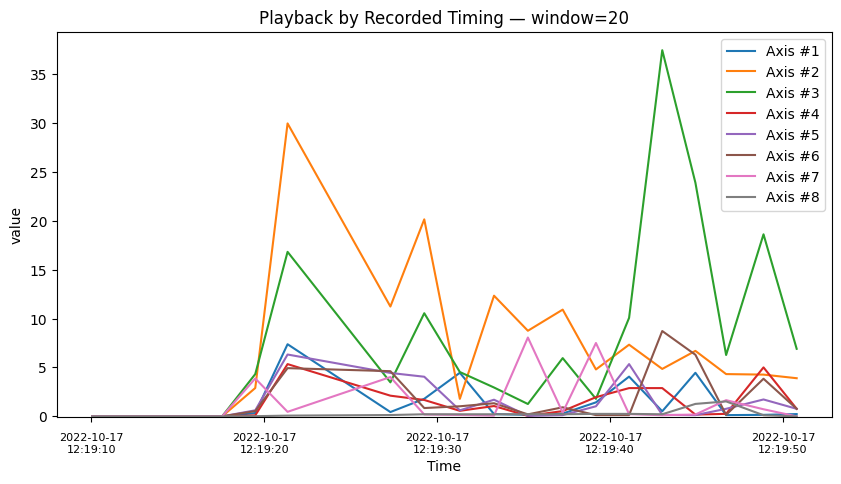

KeyboardInterrupt: 

In [86]:
# Load from DB → replay one timestamp at a time following recorded time gaps (window=20), with speed/upper-cap support
%matplotlib inline
import os, sqlite3, time, re
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import deque
from datetime import datetime, timedelta
from pathlib import Path
from IPython.display import clear_output, display

# --- DB connection ---
DSN = os.getenv("DATABASE_URL", "").strip()
def get_conn():
    if DSN:
        import psycopg2
        return psycopg2.connect(DSN), "pg"
    else:
        return sqlite3.connect(str(Path.cwd() / "local_demo.db")), "sqlite"

# --- LONG → WIDE (single batch load) ---
conn, kind = get_conn()
if kind == "pg":
    with conn.cursor() as cur:
        cur.execute("SELECT ts, axis_id, value FROM stream_samples ORDER BY ts, axis_id;")
        rows = cur.fetchall()
    conn.close()
else:
    cur = conn.cursor()
    cur.execute("SELECT ts, axis_id, value FROM stream_samples ORDER BY ts, axis_id;")
    rows = cur.fetchall(); conn.close()

df_long = pd.DataFrame(rows, columns=["ts","axis_id","value"])
assert not df_long.empty, "There is no data in the DB."

dfw = df_long.pivot(index="ts", columns="axis_id", values="value").sort_index()
# Ensure 8 axes exist; fill missing with 0 so zeros are plotted as-is
for a in range(1,9):
    if a not in dfw.columns:
        dfw[a] = 0.0
dfw = dfw[[1,2,3,4,5,6,7,8]].fillna(0.0)

# --- X-axis start value / label format (per request) ---
csv_first_dt = datetime(2022, 10, 17, 12, 18, 23)  # fixed start label on x-axis
datefmt = "%Y-%m-%d\n%H:%M:%S"                      # two-line label: date on 1st line, time on 2nd
ts_vals = dfw.index.values.astype(float)
ts0 = float(ts_vals.min())

# --- Sliding buffers / figure ---
WINDOW = 20
xbuf = deque(maxlen=WINDOW)
ybuf = {i: deque(maxlen=WINDOW) for i in range(1,9)}

fig, ax = plt.subplots(figsize=(10,5))
lines = []
for i in range(8):
    (ln,) = ax.plot([], [], label=f"Axis #{i+1}")  # do not set colors explicitly
    lines.append(ln)

ax.set_title("Playback by Recorded Timing — window=20")
ax.set_ylabel("value"); ax.set_xlabel("Time")
ax.legend(loc="upper right")
ax.xaxis.set_major_formatter(mdates.DateFormatter(datefmt))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=8))
ax.tick_params(axis='x', labelsize=8, pad=8)  # smaller labels with a bit more padding

# --- Playback parameters (reproduce recorded gaps) ---
SPEED = 1.0           # 1.0 = real-time, 5.0 = 5× faster
DRAW_EVERY = 2        # redraw every N steps (tune for performance)
MAX_SLEEP_CAP = 0.25  # cap for very long waits (seconds)
ymin_seen, ymax_seen, PAD = None, None, 0.05

# --- Scheduler: align to wall-clock so each ts appears after its original gap/SPEED ---
start_wall = time.perf_counter()
for i, (ts, row) in enumerate(dfw.iterrows()):
    rel_sec = float(ts) - ts0                   # seconds elapsed since first ts in DB
    target = start_wall + rel_sec / max(1e-9, SPEED)

    # sleep until target time (with an upper cap to avoid overly long waits)
    while True:
        now = time.perf_counter()
        remain = target - now
        if remain <= 0:
            break
        time.sleep(min(MAX_SLEEP_CAP, remain))

    # Update x-axis buffer
    xval = csv_first_dt + timedelta(seconds=rel_sec)
    xbuf.append(xval)
    xplot = mdates.date2num(list(xbuf))

    # Update 8 axes (zeros are kept as-is)
    for aid in range(1,9):
        ybuf[aid].append(float(row[aid]))

    # Update y-limits only when a new min/max appears → steadier y-axis
    y_min = min(min(ybuf[k]) for k in ybuf if len(ybuf[k])>0)
    y_max = max(max(ybuf[k]) for k in ybuf if len(ybuf[k])>0)
    changed = False
    if ymin_seen is None or y_min < ymin_seen:
        ymin_seen = y_min; changed = True
    if ymax_seen is None or y_max > ymax_seen:
        ymax_seen = y_max; changed = True

    # Draw
    if (i % DRAW_EVERY == 0) or (i == len(dfw)-1) or changed:
        for aid, ln in enumerate(lines, start=1):
            ln.set_data(xplot, list(ybuf[aid]))
        if changed:
            bottom = ymin_seen - (abs(ymin_seen) if ymin_seen!=0 else 1)*PAD
            top    = ymax_seen + (abs(ymax_seen) if ymax_seen!=0 else 1)*PAD
            ax.set_ylim(bottom, top)
        ax.relim(); ax.autoscale_view(scalex=True, scaley=False)
        clear_output(wait=True); display(fig)
        plt.pause(0.001)

print("Playback finished")

# 3. Regression Models & Residual Analysis


### Preparing training data - Queries
Read (ts, axis_id, value) from the stream_samples table and load them into a DataFrame.  
Query: SELECT ts, axis_id // value FROM <"table"> //ORDER BY ts, axis_id

In [2]:
# DB helpers + read_from_db()
import os, sqlite3
import pandas as pd
from pathlib import Path

TABLE   = "stream_samples"
DSN     = os.getenv("DATABASE_URL", "").strip()

def get_conn():
    if DSN:
        import psycopg2
        return psycopg2.connect(DSN), "pg"
    else:
        return sqlite3.connect(str(Path.cwd() / "local_demo.db")), "sqlite"

def read_from_db(table: str = TABLE):
    """Return DataFrame(ts, axis_id, value) ordered by ts, axis_id."""
    conn, kind = get_conn()
    if kind == "pg":
        q = f"SELECT ts, axis_id, value FROM {table} ORDER BY ts, axis_id;"
        with conn.cursor() as cur:
            cur.execute(q)
            rows = cur.fetchall()
        conn.close()
    else:
        q = f"SELECT ts, axis_id, value FROM {table} ORDER BY ts, axis_id;"
        cur = conn.cursor(); cur.execute(q)
        rows = cur.fetchall(); conn.close()

    if not rows:
        raise RuntimeError(f"No rows in table '{table}'.")
    df = pd.DataFrame(rows, columns=["ts","axis_id","value"])

    # ensure numeric
    df["ts"]      = pd.to_numeric(df["ts"], errors="coerce")
    df["axis_id"] = pd.to_numeric(df["axis_id"], errors="coerce", downcast="integer")
    df["value"]   = pd.to_numeric(df["value"], errors="coerce")
    df = df.dropna(subset=["ts","axis_id","value"]).reset_index(drop=True)

    return df

Read stream_samples(ts, axis_id, value) and wide pivot (index=ts, columns=1..8).

Global OFF removal: Only times when all eight axes are 0 are discarded.  
  -> Set it so that linear regression is computed only when the equipment is ON.

Generate time_s (seconds relative to the first ts=0), estimate the sampling period:
rate = 1 / median(diff(time_s))

Training/validation split: 80/20 based on time  
-> Create a self-validation window by separating training data and future data.

In [3]:
# 1) Load & pivot
df_long = read_from_db()  # ts, axis_id, value
dfw = df_long.pivot(index="ts", columns="axis_id", values="value").sort_index()

# Ensure 8 axes + NaN -> 0
axes = [1,2,3,4,5,6,7,8]
for k in axes:
    if k not in dfw.columns:
        dfw[k] = 0.0
dfw = dfw[axes].fillna(0.0)

# 2) Remove global OFF (drop timestamps where all axes are 0)
all_zero = (dfw[axes] == 0.0).all(axis=1)
df2 = dfw.loc[~all_zero].copy()
assert len(df2) > 0, "All timestamps appear to be globally OFF. Please check the raw data/insertion logic."

# 3) Estimate time_s & rate (robust)
time_col = "time_s"
ts_vals = df2.index.values.astype(float)
t0 = float(ts_vals.min())
df2[time_col] = ts_vals - t0

dt = np.diff(df2[time_col].values)
dt = dt[dt > 0]  # remove duplicate timestamps (0 interval)
median_dt = float(np.median(dt)) if len(dt) else np.nan
rate = (1.0 / median_dt) if (median_dt and median_dt > 0) else np.nan
print(f"median Δt={median_dt:.6f}s → rate≈{rate:.3f} Hz")

# 4) 80/20 split by time
df2_sorted = df2.sort_values(time_col)
cut = int(len(df2_sorted) * 0.8)
df_train = df2_sorted.iloc[:cut].copy()
df_valid = df2_sorted.iloc[cut:].copy()

print("train:", df_train.shape, "| valid:", df_valid.shape)
display(df_train.head(3)) #top 3 row When equipment is ON

median Δt=1.925000s → rate≈0.519 Hz
train: (11348, 9) | valid: (2837, 9)


axis_id,1,2,3,4,5,6,7,8,time_s
ts,,,,,,,,,
56.476,0.33876,2.89931,4.32261,0.10324,0.61943,0.54200,3.87537,0.01962,0.000
58.345,7.37465,29.94201,16.81602,5.34255,6.32330,4.92959,0.46504,0.07848,1.869
64.292,0.44300,11.22826,3.47918,2.11637,4.43922,4.61988,4.01847,0.13734,7.816


# 3.1 Linear regression (Fit) by axis + statistics/residual calculation
1. For each axis 1–8, use only rows in df_train where that axis value is not exactly 0.0  
2. Fit linear regression (time -> axis value)
3. Compute & store predictions / residuals
4. Positive-residual percentiles (p95,p99) - Display it to check trends and adjust the values later

In [4]:
# ML-1) Per-axis linear regression (Time -> Axis), compute residuals & stats
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

axes = [1,2,3,4,5,6,7,8]

models = {}       # axis -> fitted LinearRegression object
stats_df = None   # summary table
residuals = {}    # axis -> pd.Series of residuals (indexed by ts)
preds = {}        # axis -> pd.Series of y_hat (indexed by ts)

rows = []
for k in axes:
    # exclude only exact zeros for that axis (keep others)
    mask = (df_train[k] != 0.0)
    X = df_train.loc[mask, [time_col]].values
    y = df_train.loc[mask, k].values
    if len(y) < 2:
        continue

    lr = LinearRegression().fit(X, y)
    yhat = lr.predict(X)
    res = y - yhat

    # store
    models[k] = lr
    idx = df_train.loc[mask].index
    residuals[k] = pd.Series(res, index=idx, name=f"res_axis{k}")
    preds[k]     = pd.Series(yhat, index=idx, name=f"yhat_axis{k}")

    # positive-residual percentiles (useful later for MinC/MaxC hints)
    pos = res[res > 0]
    p95 = float(np.percentile(pos, 95)) if len(pos) else 0.0
    p99 = float(np.percentile(pos, 99)) if len(pos) else 0.0

    rows.append(dict(
        axis=k, n=len(y),
        slope=float(lr.coef_[0]),
        intercept=float(lr.intercept_),
        r2=float(r2_score(y, yhat)) if len(y) > 1 else np.nan,
        res_std=float(np.std(res, ddof=1)) if len(res) > 1 else np.nan,
        pos_p95=p95, pos_p99=p99
    ))

stats_df = pd.DataFrame(rows).set_index("axis").sort_index().round(6)
display(stats_df)

,n,slope,intercept,r2,res_std,pos_p95,pos_p99
axis,,,,,,,
1,10998,0.000000,2.110252,0.000000,3.310148,11.804708,19.491754
2,11074,-0.000002,10.338646,0.000011,8.081989,21.923565,34.753912
3,11059,-0.000006,7.971161,0.000291,5.997909,20.751426,27.011802
4,10939,0.000001,1.751237,0.000133,2.260597,9.085165,11.850204
5,11049,-0.000001,2.764868,0.000016,2.802088,8.725962,14.215875
6,10890,0.000001,1.700478,0.000061,2.743853,11.797946,15.718394
7,10935,0.000000,2.500574,0.000004,3.069165,5.592870,5.604441
8,10955,0.000000,0.287272,0.000037,0.676534,3.805784,4.342564


## 3.1.1 SSR Plot (Self-diagnosis and review)
Review the slope and intercept values ​​of linear regression for each axis through a graph.

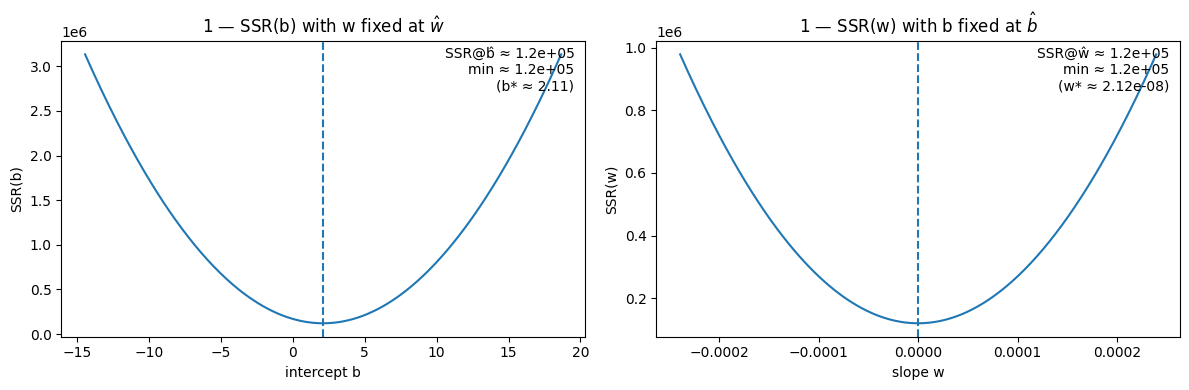

In [5]:
# Parameter-slice plots: SSR(b) with w fixed at ŵ, and SSR(w) with b fixed at b̂
import numpy as np
import matplotlib.pyplot as plt

def plot_ssr_slices(axis_k, n=301, k_sigma=5.0,
                    annotate=True, print_values=True, return_values=False):
    """
    Plot and optionally print/return sum-of-squared-residuals (SSR) slices
    for a simple linear model y = w*t + b.

    Parameters
    ----------
    axis_k : int or str
        Axis ID or column name (e.g., 1..8 or 'Axis #1').
    n : int, default 301
        Number of grid points per slice.
    k_sigma : float, default 5.0
        Span scale around the optimum using residual std (≈ k_sigma * σ_res).
    annotate : bool, default True
        If True, annotate plots with numeric values.
    print_values : bool, default True
        If True, print numeric summary to the console.
    return_values : bool, default False
        If True, return a dictionary containing grids and SSR values.

    Notes
    -----
    - Uses the same training mask: excludes only exact zeros for the chosen axis.
    - Assumes the following exist in the outer scope:
        * df_train : training DataFrame
        * time_col : name of the time column (numeric seconds)
        * models   : dict-like mapping {axis_col: fitted LinearRegression}
    """
    # If axis_k is an int, map it to a likely column name in df_train
    col = axis_k
    if isinstance(axis_k, int):
        candidates = [f"Axis #{axis_k}", f"Axis{axis_k}", f"Axis {axis_k}", f"axis_{axis_k}"]
        for c in candidates:
            if c in df_train.columns:
                col = c
                break

    # Same mask used for training: exclude only exact zeros for this axis
    mask = (df_train[col] != 0.0)
    t = df_train.loc[mask, time_col].values.astype(float)  # time in seconds
    y = df_train.loc[mask, col].values.astype(float)

    lr = models[col] if col in models else models[axis_k]
    w_hat = float(lr.coef_[0])
    b_hat = float(lr.intercept_)

    # Residual std to set a reasonable span
    yhat = lr.predict(t.reshape(-1, 1))
    res  = y - yhat
    res_std = float(np.std(res, ddof=1)) if len(res) > 1 else 1.0
    t_range = float(np.ptp(t)) if t.size else 1.0

    # Choose spans so that the induced y-shift is ~k_sigma * res_std
    delta_b = k_sigma * res_std
    delta_w = (k_sigma * res_std) / max(t_range, 1e-9)

    # 1) SSR as a function of b (fix w = ŵ)
    b_grid = np.linspace(b_hat - delta_b, b_hat + delta_b, n)
    # y - (ŵ t + b)
    SSR_b = np.sum((y[:, None] - (w_hat * t[:, None] + b_grid[None, :]))**2, axis=0)

    # 2) SSR as a function of w (fix b = b̂)
    w_grid = np.linspace(w_hat - delta_w, w_hat + delta_w, n)
    # y - (w t + b̂)
    SSR_w = np.sum((y[:, None] - (w_grid[None, :] * t[:, None] + b_hat))**2, axis=0)

    # SSR at the fitted optimum (shared by both slices)
    SSR_opt = float(np.sum(res**2))

    # Grid minima & locations
    idx_b_min = int(np.argmin(SSR_b)); b_star = float(b_grid[idx_b_min]); SSR_b_min = float(SSR_b[idx_b_min])
    idx_w_min = int(np.argmin(SSR_w)); w_star = float(w_grid[idx_w_min]); SSR_w_min = float(SSR_w[idx_w_min])

    # --- plots ---
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # SSR(b)
    axs[0].plot(b_grid, SSR_b)
    axs[0].axvline(b_hat, ls="--")
    axs[0].set_title(f"{col} — SSR(b) with w fixed at $\hat w$")
    axs[0].set_xlabel("intercept b"); axs[0].set_ylabel("SSR(b)")
    if annotate:
        axs[0].annotate(
            f"SSR@b̂ ≈ {SSR_opt:.3g}\nmin ≈ {SSR_b_min:.3g}\n(b* ≈ {b_star:.3g})",
            xy=(0.98, 0.98), xycoords="axes fraction", ha="right", va="top"
        )

    # SSR(w)
    axs[1].plot(w_grid, SSR_w)
    axs[1].axvline(w_hat, ls="--")
    axs[1].set_title(f"{col} — SSR(w) with b fixed at $\hat b$")
    axs[1].set_xlabel("slope w"); axs[1].set_ylabel("SSR(w)")
    if annotate:
        axs[1].annotate(
            f"SSR@ŵ ≈ {SSR_opt:.3g}\nmin ≈ {SSR_w_min:.3g}\n(w* ≈ {w_star:.3g})",
            xy=(0.98, 0.98), xycoords="axes fraction", ha="right", va="top"
        )

    fig.tight_layout(); plt.show()

    if return_values:
        return {
            "axis": col,
            "w_hat": w_hat, "b_hat": b_hat,
            "SSR_opt": SSR_opt,
            "b_grid": b_grid, "SSR_b": SSR_b, "b_star": b_star, "SSR_b_min": SSR_b_min,
            "w_grid": w_grid, "SSR_w": SSR_w, "w_star": w_star, "SSR_w_min": SSR_w_min,
        }

# Example usage
# plot_ssr_slices(axis_k=1, return_values=True)
plot_ssr_slices(axis_k=1)


# 3.2 Save the axis-specific plot (scatter plot + regression line / residual time plot)  
- Facilitates analysis through visualization  
- Data verification using P95 and P99, which are mainly used for analysis

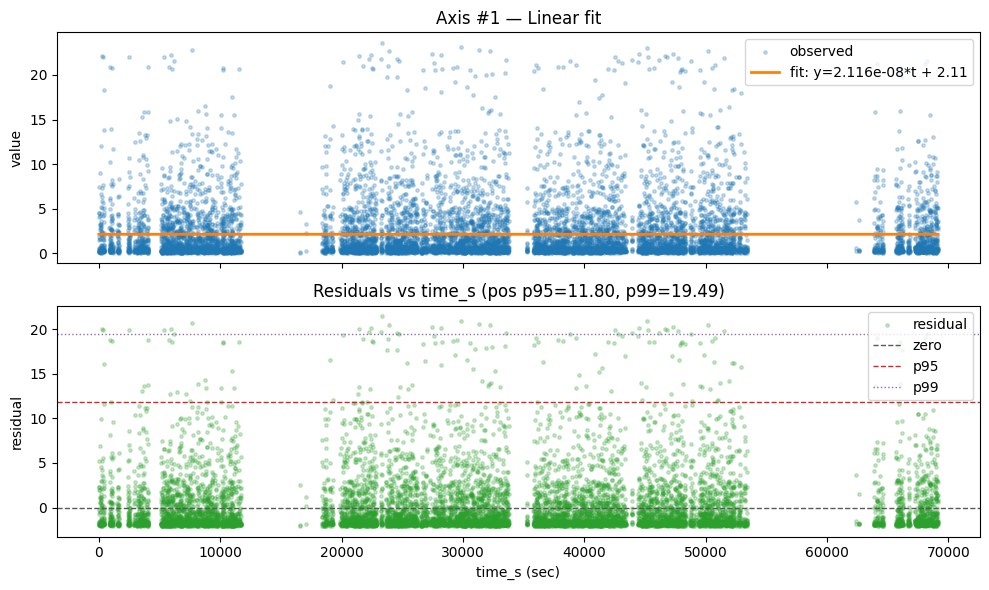

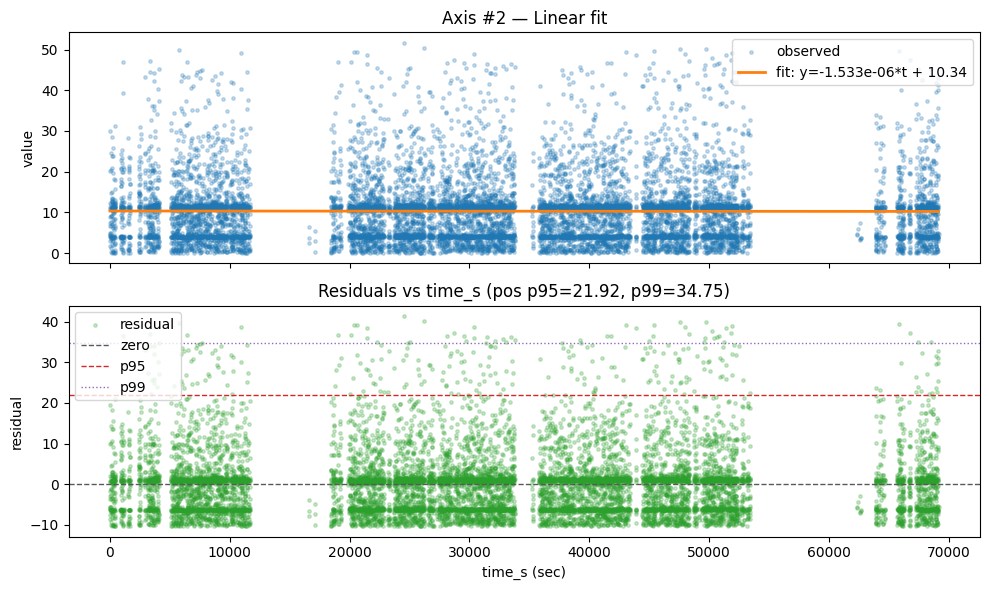

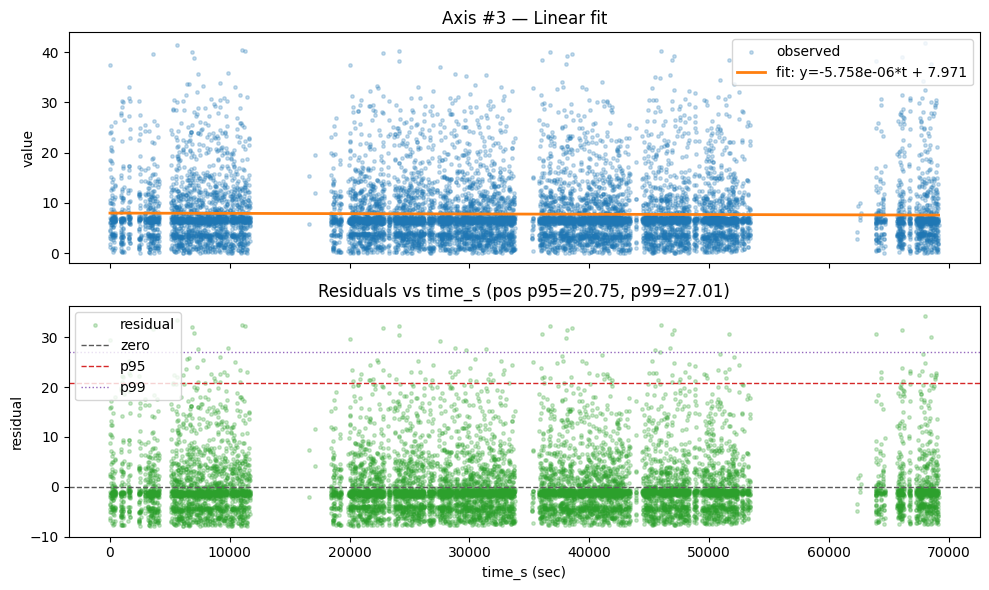

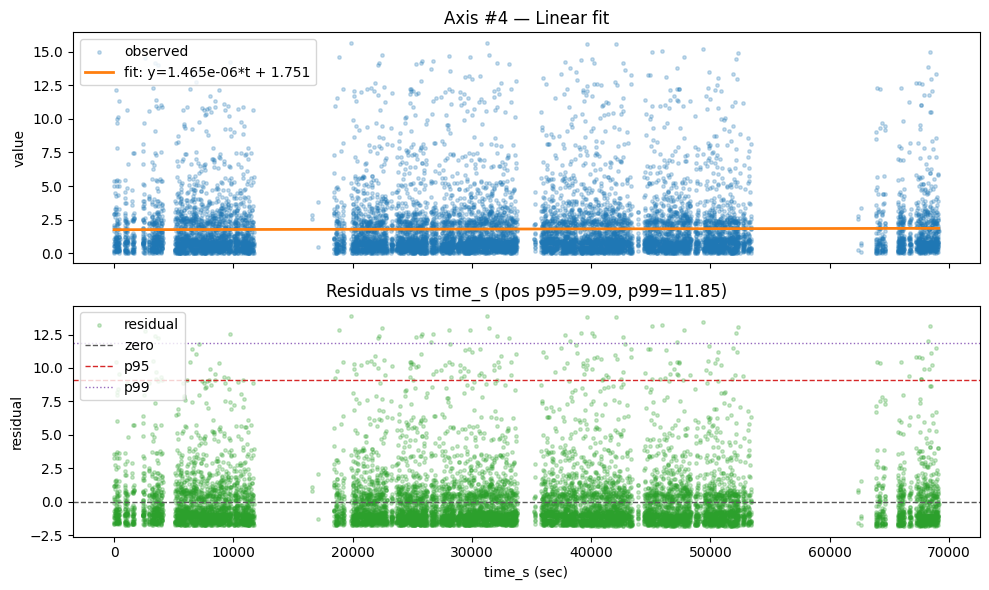

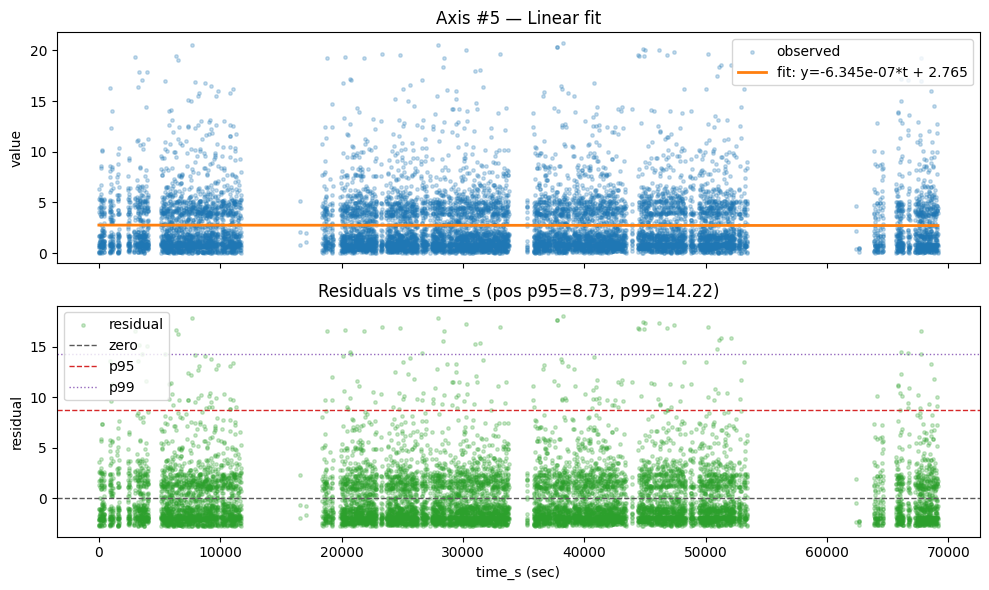

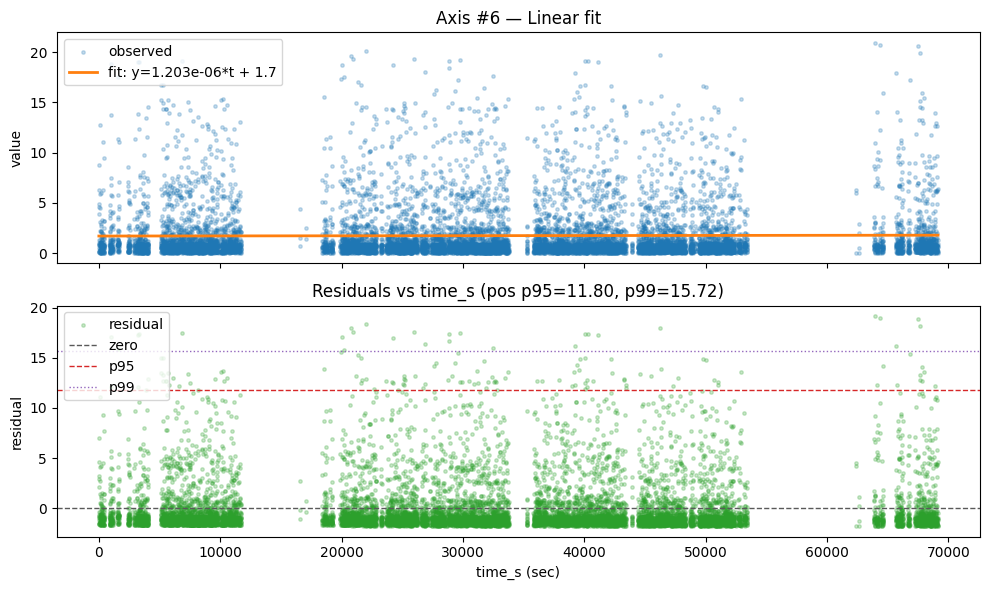

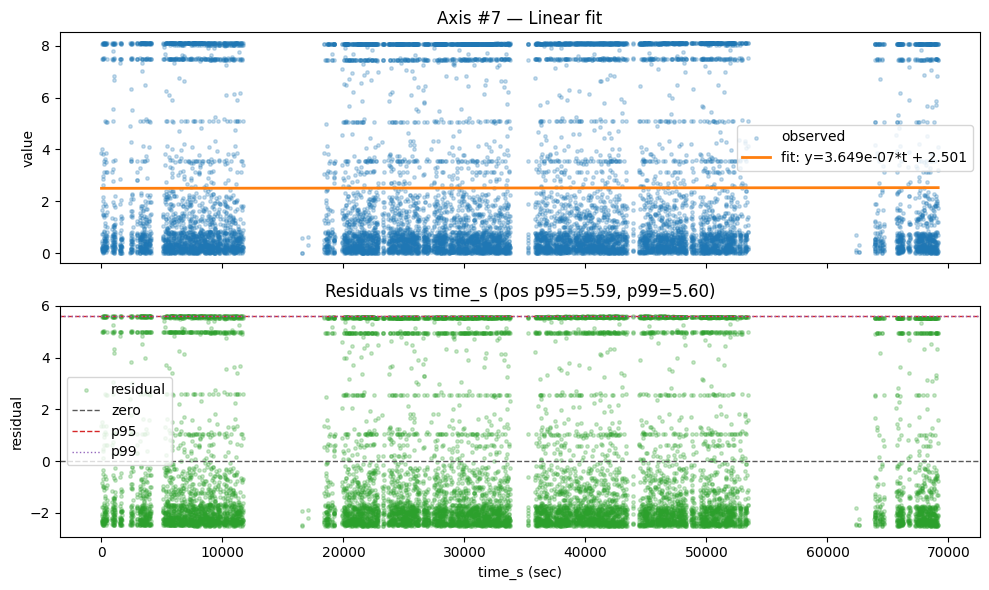

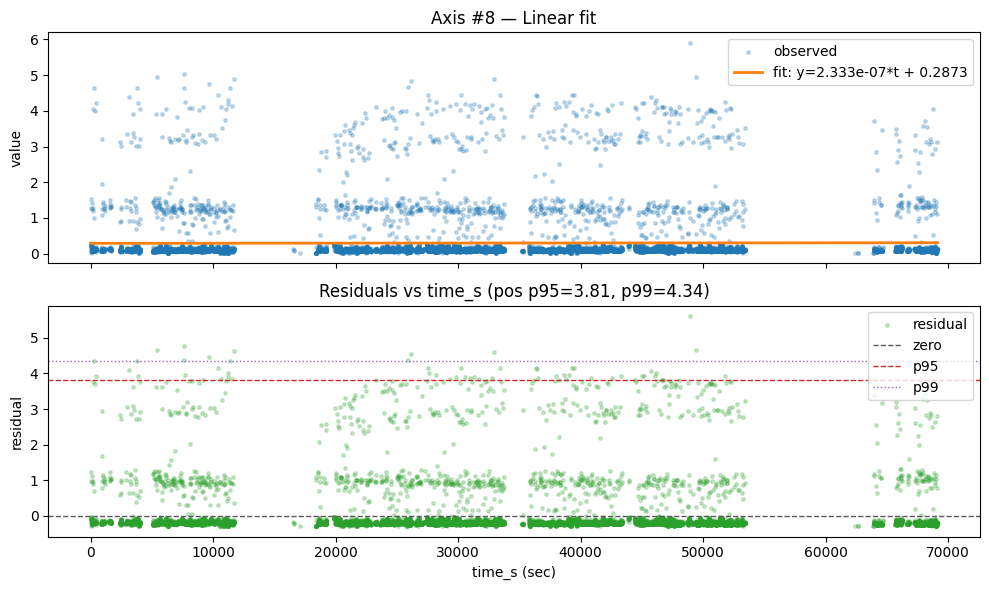

In [6]:
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path

SAVE_DIR = Path("plots"); SAVE_DIR.mkdir(exist_ok=True)

# Desired colors (Tableau 10 palette)
C_POINT = "tab:blue"     # observed points
C_FIT   = "tab:orange"   # regression line
C_RES   = "tab:green"    # residual scatter
C_ZERO  = "0.35"         # y=0 guide (gray)
C_P95   = "tab:red"      # +95% line
C_P99   = "tab:purple"   # +99% line

for k in axes:
    if k not in models:
        continue
    lr = models[k]
    msk = (df_train[k] != 0.0)
    t = df_train.loc[msk, time_col].values
    y = df_train.loc[msk, k].values

    order = np.argsort(t)
    t_sorted = t[order]; y_sorted = y[order]
    y_fit = lr.coef_[0] * t_sorted + lr.intercept_
    res   = y_sorted - y_fit

    pos = res[res>0]
    p95 = float(np.percentile(pos,95)) if len(pos) else 0.0
    p99 = float(np.percentile(pos,99)) if len(pos) else 0.0

    fig, axs = plt.subplots(2,1,figsize=(10,6), sharex=True)

    # (top) time vs observed with fit
    axs[0].scatter(t_sorted, y_sorted, s=6, alpha=0.25, color=C_POINT,
                   label="observed", rasterized=True)
    axs[0].plot(t_sorted, y_fit, lw=2, color=C_FIT,
                label=f"fit: y={lr.coef_[0]:.4g}*t + {lr.intercept_:.4g}", zorder=3)
    axs[0].set_title(f"Axis #{k} — Linear fit")
    axs[0].set_ylabel("value")
    axs[0].legend(loc="best")

    # (bottom) residuals vs time_s (scatter)
    axs[1].scatter(t_sorted, res, s=6, alpha=0.25, color=C_RES,
                   rasterized=True, label="residual")
    axs[1].axhline(0.0, ls="--", lw=1, color=C_ZERO, label="zero")
    if p95>0: axs[1].axhline(p95, ls="--", lw=1, color=C_P95, label="p95")
    if p99>0: axs[1].axhline(p99, ls=":",  lw=1, color=C_P99, label="p99")
    axs[1].set_title(f"Residuals vs time_s (pos p95={p95:.2f}, p99={p99:.2f})")
    axs[1].set_xlabel("time_s (sec)")
    axs[1].set_ylabel("residual")
    axs[1].legend(loc="best")

    fig.tight_layout()
    fig.savefig(SAVE_DIR / f"axis_{k}_fit_and_residuals_scatter.png", dpi=140)
    plt.show()

# 4 Threshold Discovery & Justification
### 4.1 Data-driven logic for determining per-axis thresholds (MinC/MaxC) and durations (T_LONG/T_SHORT)
Differentiate the definitions for current-value alerts and errors:  
 - Alert: triggered when the value stays above a threshold for a long duration (apply T_long)
 - Error: triggered when a higher value is sustained for a short duration (apply T_short)
1. Uses trimmed (top-2%) percentiles of positive residuals to set per-axis MinC/MaxC
2. Converts seconds → sample counts using the sampling rate (0.519 Hz)
3. efines T_LONG (Alert) and T_SHORT (Error) per axis via run-length distributions

-> In this data, there are not many values ​​that maintain the threshold for a long time, so pct_minc = 75, pct_maxc = 95  
-> T-long-count : 3 / T-short-count : 2 (Alarm/error display when values ​​exceeding the set value are displayed continuously more than count)

In [7]:
# Pick MinC/MaxC (trimmed percentiles) and T_LONG/T_SHORT (run-length based)
import numpy as np
import pandas as pd
import math

# --- Config you may tune ---
axes = [1,2,3,4,5,6,7,8]
trim_top = 0.02        # trim top 2% of positive residuals before percentiles
pct_minc = 75          # MinC from p75
pct_maxc = 95          # MaxC from p95
T_long_sec_default  = 5.0  # default Alert duration (sec)
T_short_sec_default = 3.0   # default Error duration (sec)
# For data-driven refinement using run-lengths:
q_long = 0.8          # make T_LONG at least the 80th percentile of MinC-runs
q_short = 0.5        # make T_SHORT at least the 50th percentile of MaxC-runs (median)

def run_lengths(mask_1d: np.ndarray):
    """Return lengths of consecutive True runs in a boolean 1D array."""
    runs, c = [], 0
    for b in mask_1d:
        if b: c += 1
        elif c: runs.append(c); c = 0
    if c: runs.append(c)
    return np.array(runs, dtype=int)

def trimmed_percentiles(pos_vals, trim_ratio, p_list):
    pos_sorted = np.sort(pos_vals)
    if trim_ratio > 0:
        cut = int(len(pos_sorted) * (1.0 - trim_ratio))
        cut = max(cut, 1)
        pos_sorted = pos_sorted[:cut]
    return [float(np.percentile(pos_sorted, p)) for p in p_list]

# 1) MinC/MaxC per axis from positive residuals (trimmed p95/p99)
th = {}         # axis -> {"MinC":..., "MaxC":...}
rows = []
for k in axes:
    if k not in residuals:
        continue
    res = residuals[k].dropna().values
    pos = res[res > 0]
    if len(pos) < 20:
        # Robust fallback if too few positives
        med = float(np.median(pos)) if len(pos) else 0.0
        mad = float(np.median(np.abs(pos - med))) if len(pos) else 0.0
        MinC = med + 2.0*mad
        MaxC = med + 3.0*mad
        src = "robust(median+MAD)"
    else:
        MinC, MaxC = trimmed_percentiles(pos, trim_top, [pct_minc, pct_maxc])
        src = f"trim{int(trim_top*100)}%-p{pct_minc}/p{pct_maxc}"
    th[k] = {"MinC": MinC, "MaxC": MaxC, "source": src}
    rows.append(dict(axis=k, n_pos=len(pos), MinC=MinC, MaxC=MaxC, source=src))

th_df = pd.DataFrame(rows).set_index("axis").round(3)
display(th_df)

# 2) Convert target seconds to samples using rate
T_long_count_default  = int(math.ceil(T_long_sec_default  * rate))
T_short_count_default = int(math.ceil(T_short_sec_default * rate))
print(f"rate≈{rate:.3f} Hz → defaults: T_LONG={T_long_count_default} samp (~{T_long_sec_default}s), "
      f"T_SHORT={T_short_count_default} samp (~{T_short_sec_default}s)")

# 3) Data-driven refinement via run-lengths on training residuals
T_counts = {}
for k in axes:
    if k not in residuals:
        continue
    # align residual with df_train index order
    r = residuals[k].reindex(df_train.index).fillna(0.0).values
    MinC, MaxC = th[k]["MinC"], th[k]["MaxC"]

    runs_alert = run_lengths(r >= MinC)  # lengths where r >= MinC
    runs_error = run_lengths(r >= MaxC)  # lengths where r >= MaxC

    def choose_T(runs, default_count, quantile):
        if runs.size == 0:
            return default_count
        q = int(np.percentile(runs, quantile*100))
        # Alert: "only the longest X% survive" → use max(default, q)
        # Error: we keep it short; we'll apply a different rule below
        return max(default_count, q)

    # Alert uses long duration: conservative (95th percentile of MinC-runs)
    T_long_count  = choose_T(runs_alert, T_long_count_default, q_long)

    # Error uses short duration: at least default; also bounded by median of MaxC-runs
    if runs_error.size == 0:
        T_short_count = T_short_count_default
    else:
        qerr = int(np.percentile(runs_error, q_short*100))   # if q_short = 0.5, this is the median
        T_short_count = max(T_short_count_default, qerr)     #  never goes below the default value
        # => keep it short (<= median) but not below the default

    T_counts[k] = {"T_LONG_count": int(T_long_count), "T_SHORT_count": int(T_short_count)}

T_df = pd.DataFrame(T_counts).T
display(T_df)

,n_pos,MinC,MaxC,source
axis,,,,
1,3164,5.029,10.685,trim2%-p75/p95
2,5667,7.317,19.130,trim2%-p75/p95
3,3233,9.510,19.320,trim2%-p75/p95
4,3671,2.683,7.789,trim2%-p75/p95
5,4208,2.983,7.394,trim2%-p75/p95
6,2637,4.863,10.625,trim2%-p75/p95
7,3381,5.560,5.591,trim2%-p75/p95
8,1153,2.762,3.751,trim2%-p75/p95


rate≈0.519 Hz → defaults: T_LONG=3 samp (~5.0s), T_SHORT=2 samp (~3.0s)


,T_LONG_count,T_SHORT_count
1,3,2
2,3,2
3,3,2
4,3,2
5,3,2
6,3,2
7,3,2
8,3,2


## 4.1.1 Check MinC/MaxC/Run-length through graph (Add for analysis)
(a) Positive residuals histogram with MinC/MaxC lines  
(b) Run-length CDFs for (r>=MinC) and (r>=MaxC), with chosen T markers  

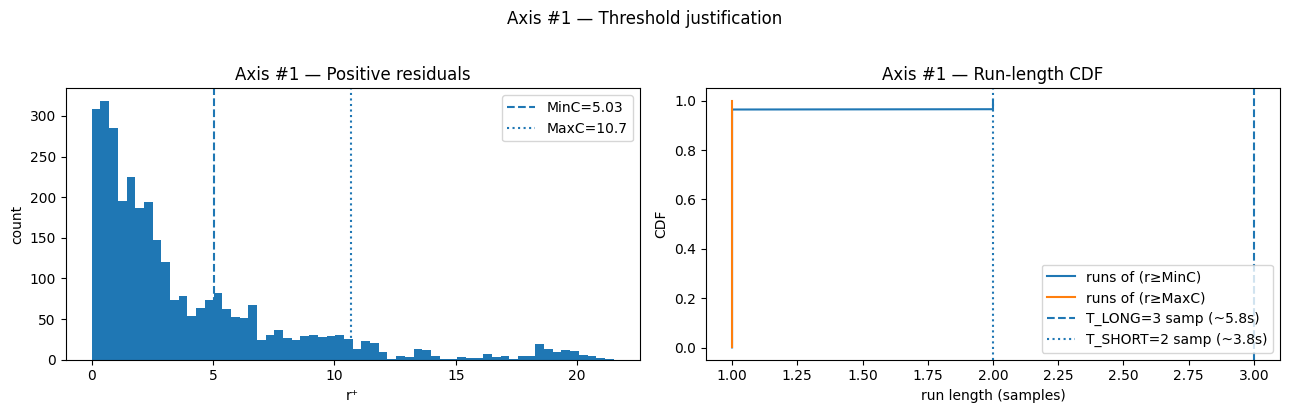

In [8]:
# Justification plots per axis:
import numpy as np
import matplotlib.pyplot as plt

def plot_threshold_justification(axis_k):
    assert axis_k in residuals, f"residuals[{axis_k}] not found."
    MinC = th[axis_k]["MinC"]; MaxC = th[axis_k]["MaxC"]
    T_LONG = T_counts[axis_k]["T_LONG_count"]; T_SHORT = T_counts[axis_k]["T_SHORT_count"]

    # (a) Positive residuals histogram
    res = residuals[axis_k].dropna().values
    pos = res[res > 0]
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    if len(pos) > 0:
        axs[0].hist(pos, bins=60)
        axs[0].axvline(MinC, ls="--", label=f"MinC={MinC:.3g}")
        axs[0].axvline(MaxC, ls=":",  label=f"MaxC={MaxC:.3g}")
        axs[0].set_title(f"Axis #{axis_k} — Positive residuals")
        axs[0].set_xlabel("r⁺"); axs[0].set_ylabel("count"); axs[0].legend()
    else:
        axs[0].text(0.5, 0.5, "No positive residuals", ha="center", va="center")
        axs[0].set_axis_off()

    # (b) Run-length CDFs
    r_train = residuals[axis_k].reindex(df_train.index).fillna(0.0).values
    rl_alert = run_lengths(r_train >= MinC)
    rl_error = run_lengths(r_train >= MaxC)

    def cdf_curve(runs):
        if runs.size == 0:
            return np.array([0]), np.array([0.0])
        xs = np.sort(runs)
        ys = np.arange(1, len(xs)+1)/len(xs)
        return xs, ys

    xA, yA = cdf_curve(rl_alert)
    xE, yE = cdf_curve(rl_error)
    axs[1].plot(xA, yA, label="runs of (r≥MinC)")
    axs[1].plot(xE, yE, label="runs of (r≥MaxC)")
    axs[1].axvline(T_LONG, ls="--", label=f"T_LONG={T_LONG} samp (~{T_LONG/rate:.1f}s)")
    axs[1].axvline(T_SHORT, ls=":",  label=f"T_SHORT={T_SHORT} samp (~{T_SHORT/rate:.1f}s)")
    axs[1].set_title(f"Axis #{axis_k} — Run-length CDF")
    axs[1].set_xlabel("run length (samples)"); axs[1].set_ylabel("CDF")
    axs[1].legend(loc="lower right")

    fig.suptitle(f"Axis #{axis_k} — Threshold justification", y=1.02, fontsize=12)
    fig.tight_layout(); plt.show()

# Example: Axis 1 test
plot_threshold_justification(axis_k=1)

# for k in axes: plot_threshold_justification(axis_k=k)

# 4.2 Verification 
 - Utilizing the latter 20% of learning data (Future data)
 - Display the result of "alerts/hour" , "error/hour" 

In [9]:
# Apply the chosen thresholds to validation set to estimate alarms/hour
from collections import Counter
# --- Safety guard: ensure df_valid has a usable time column (time_s) ---
import pandas as pd
import numpy as np
import re

def robust_time_to_seconds(series: pd.Series) -> pd.Series:
    trials = [
        dict(utc=False), dict(utc=True),
        dict(utc=False, infer_datetime_format=True), dict(utc=True, infer_datetime_format=True),
        dict(utc=False, format="%Y-%m-%dT%H:%M:%S"),
        dict(utc=True,  format="%Y-%m-%dT%H:%M:%S"),
        dict(utc=True,  format="%Y-%m-%dT%H:%M:%S.%fZ"),
        dict(utc=True,  format="%Y-%m-%dT%H:%M:%SZ"),
    ]
    for kw in trials:
        try:
            dt = pd.to_datetime(series, errors="coerce", **kw)
        except Exception:
            continue
        if dt.notna().sum() > 0:
            t0 = dt.dropna().iloc[0]
            return (dt - t0).dt.total_seconds().astype(float)
    # numeric fallback
    s = series.astype(str).str.strip()
    s = s.str.replace(r"[^\d,.\-+eE]", "", regex=True)\
         .str.replace(r"(?<=\d),(?=\d{3}(\D|$))", "", regex=True)\
         .str.replace(",", ".", regex=False)
    x = pd.to_numeric(s, errors="coerce")
    assert x.notna().any(), "Time column cannot be parsed as a number/date."
    return (x - float(x.dropna().iloc[0])).astype(float)

assert 'df_valid' in globals(), "df_valid is not in memory."

if 'time_s' in df_valid.columns:
    time_col = 'time_s'
else:
    # Try to find a candidate time column and create time_s
    candidates = [c for c in df_valid.columns if c.lower() in ('time','timestamp','datetime')]
    if not candidates:
        raise KeyError("df_valid does not have a time column (expected: time_s or Time/Timestamp/Datetime)")
    df_valid = df_valid.copy()
    df_valid['time_s'] = robust_time_to_seconds(df_valid[candidates[0]])
    time_col = 'time_s'

print(f"[OK] time_col = {time_col},  df_valid columns = {list(df_valid.columns)[:10]} ...")

def evaluate_on_valid(df_valid, models, th, T_counts, time_col="time_s"):
    events = []  # (axis, level, ts_start, ts_end, peak_dev)

    for k in axes:
        if k not in models: 
            continue
        a = float(models[k].coef_[0]); b = float(models[k].intercept_)
        MinC, MaxC = th[k]["MinC"], th[k]["MaxC"]
        T_LONG  = T_counts[k]["T_LONG_count"]
        T_SHORT = T_counts[k]["T_SHORT_count"]

        # state
        open_level, ts_start, peak = None, None, 0.0
        cnt_min = cnt_max = 0

        tvals = df_valid[time_col].values
        yvals = df_valid[k].values
        for ts, y in zip(tvals, yvals):
            yhat = a*ts + b
            dev  = max(0.0, y - yhat)  # positive residual only

            # counters
            if dev >= MaxC:
                cnt_max += 1; cnt_min = 0
                level = "ERROR"
            elif dev >= MinC:
                cnt_min += 1; cnt_max = 0
                level = "ALERT"
            else:
                # close if open
                if open_level is not None:
                    events.append((k, open_level, ts_start, ts, peak))
                open_level, ts_start, peak = None, None, 0.0
                cnt_min = cnt_max = 0
                continue

            # open/upgrade logic with durations
            if level == "ERROR":
                if open_level is None and cnt_max >= T_SHORT:
                    open_level, ts_start = "ERROR", ts - (T_SHORT-1)*(tvals[1]-tvals[0] if len(tvals)>1 else 0)
                elif open_level == "ALERT":  # upgrade
                    open_level = "ERROR"
            else:  # ALERT
                if open_level is None and cnt_min >= T_LONG:
                    open_level, ts_start = "ALERT", ts - (T_LONG-1)*(tvals[1]-tvals[0] if len(tvals)>1 else 0)

            peak = max(peak, dev)

        if open_level is not None:
            events.append((k, open_level, ts_start, tvals[-1], peak))

    # rates
    dur_sec = float(df_valid[time_col].iloc[-1] - df_valid[time_col].iloc[0])
    hours = max(dur_sec / 3600.0, 1e-9)
    c_alert = Counter([e[0] for e in events if e[1]=="ALERT"])
    c_error = Counter([e[0] for e in events if e[1]=="ERROR"])

    summary = pd.DataFrame({
        "alerts/hr": {k: c_alert.get(k,0)/hours for k in axes},
        "errors/hr": {k: c_error.get(k,0)/hours for k in axes},
    }).round(3)
    return summary, events

valid_rates, valid_events = evaluate_on_valid(df_valid, models, th, T_counts, time_col=time_col)
display(valid_rates)
print(f"Total events: {len(valid_events)}")

[OK] time_col = time_s,  df_valid columns = [1, 2, 3, 4, 5, 6, 7, 8, 'time_s'] ...


,alerts/hr,errors/hr
1,0.000,0.000
2,0.623,0.934
3,0.311,0.623
4,0.000,0.000
5,0.311,1.246
6,0.000,0.000
7,0.000,0.000
8,0.000,0.000


Total events: 13


# Creating Syntetic Data (Done)
RNG_SEED = None  -> Set it to be randomly generated within the desired specifications each time you attempt to generate synthetic data  
TOL_PCT = Setting the criteria for judging the amount of change compared to the average and standard deviation of existing data  
Mean / SD target mode -> Set the amount of change compared to the average and standard deviation of the existing data  

In [ ]:
# # Synthetic dataset generator (v6) — Nonnegativity Guaranteed (α>0, β>=0), mean/std targets + final alignment
# # Paste and run to create ./data/RMBR4-2_export_synth_v6.csv

# import pandas as pd, numpy as np, re, random
# from pathlib import Path
# from datetime import datetime, timedelta

# # ================= CONFIG =================
# RNG_SEED     = None
# TARGET_ROWS  = None
# OUTPUT_NAME  = "RMBR4-2_export_synth_v6.csv"
# TIME_START   = None                  # "YYYY-MM-DD HH:MM:SS" or None(now)

# TOL_PCT      = 2.0                   # Tolerance (±%)
# MAX_ITER     = 30
# MIN_POS_FRAC = 0.01                  # ON floor (as fraction of axis mean)
# ON_ZERO_RATE_TARGET = 0.001

# # Mean/Std target mode
# MEAN_MODE  = "within_tol"            # "exact" | "within_tol" | "scale" | "shift"
# MEAN_BIAS  = 0.01                    # Bias for within_tol (+0.01 => +1%)
# MEAN_SCALE = 1.00                    # Scale factor for "scale" mode
# MEAN_SHIFT = 0.00                    # Offset for "shift" mode (A)

# SD_MODE    = "scale"                 # "exact" | "within_tol" | "scale"
# SD_BIAS    = 0.00
# SD_SCALE   = 1.04
# # ==========================================

# if RNG_SEED is not None:
#     np.random.seed(RNG_SEED); random.seed(RNG_SEED)
# else:
#     np.random.seed(None); random.seed()

# # 1) Source
# CWD = Path.cwd()
# CANDIDATES = [CWD/"RMBR4-2_export_test.csv", CWD/"data"/"RMBR4-2_export_test.csv", Path("/mnt/data/RMBR4-2_export_test.csv")]
# SRC = next((p for p in CANDIDATES if p.exists()), None)
# if SRC is None: raise FileNotFoundError("Cannot find RMBR4-2_export_test.csv.")
# print("✅ Source:", SRC)
# df_src = pd.read_csv(SRC, low_memory=False)
# N_src  = len(df_src)
# print("Rows in source:", N_src)

# # 2) Axis detect
# axis_pat  = re.compile(r'^(axis\s*#?\s*[1-8]|axis[ _-]?[1-8])$', re.IGNORECASE)
# axis_cols = [c for c in df_src.columns if axis_pat.match(str(c).strip())]
# if not axis_cols:
#     axis_cols = [f"Axis #{i}" for i in range(1,9)]
# axis_cols = sorted(axis_cols, key=lambda x: int(re.search(r'([1-8])', str(x)).group(1)))
# print("Using Axis columns:", axis_cols)

# # 3) time cols
# time_like   = [c for c in df_src.columns if str(c).lower() in ("time","timestamp","datetime")]
# time_s_like = [c for c in df_src.columns if str(c).lower() in ("time_s","times","t_s")]
# if not time_like and not time_s_like:
#     for c in df_src.columns:
#         if "time" in str(c).lower() and "ms" not in str(c).lower():
#             time_like.append(c); break

# # 4) ON/OFF mask
# A = df_src[axis_cols].fillna(0.0).astype(float)
# off_mask = (A == 0.0).all(axis=1)
# on_mask  = ~off_mask
# assert on_mask.any(), "No ON segment"
# print(f"ON rows: {on_mask.sum():,} | OFF rows: {off_mask.sum():,}")

# # 5) dt estimate
# def estimate_dt_seconds():
#     if time_like:
#         t = pd.to_datetime(df_src[time_like[0]], errors="coerce")
#         dt = t.diff().dt.total_seconds(); dt = dt[dt>0].median()
#         if pd.notna(dt) and dt>0: return float(dt)
#     if time_s_like:
#         s = pd.to_numeric(df_src[time_s_like[0]], errors="coerce")
#         ds = s.diff(); ds = ds[ds>0].median()
#         if pd.notna(ds) and ds>0: return float(ds)
#     return 1.0
# dt_sec = estimate_dt_seconds(); print(f"Estimated dt: {dt_sec:.3f} sec")

# # 6) ON stats
# mu = A[on_mask].mean(axis=0).values
# sd = A[on_mask].std(axis=0, ddof=1).replace(0, 1e-9).values
# print("\nSource ON-stats:")
# print(pd.DataFrame({"axis":axis_cols,"mu_on":mu,"sd_on":sd}).to_string(index=False))

# # 7) run lengths
# def run_lengths(mask_bool: pd.Series, value: bool):
#     grp = (mask_bool != mask_bool.shift()).cumsum()
#     lens = mask_bool.groupby(grp).sum() if value else (~mask_bool).groupby(grp).sum()
#     return [int(l) for m,l in zip(mask_bool.groupby(grp).first(), lens) if bool(m)==value and l>0]
# on_runs  = run_lengths(on_mask, True)  or [max(1, int(on_mask.mean()*100))]
# off_runs = run_lengths(on_mask, False) or [max(1, int((~on_mask).mean()*100))]
# print(f"\nRun lengths -> ON (n={len(on_runs)}), OFF (n={len(off_runs)})")

# # 8) N_out & sequence
# N_out = N_src if TARGET_ROWS is None else int(TARGET_ROWS)
# def sample_seq():
#     seq, total = [], 0
#     state = True if random.random() < on_mask.mean() else False
#     while total < N_out:
#         L = random.choice(on_runs if state else off_runs)
#         seq.append((state, L)); total += L; state = not state
#     if total > N_out:
#         s,L = seq[-1]; seq[-1] = (s, L-(total-N_out))
#     return seq
# seq = sample_seq()
# counts = {True: sum(L for s,L in seq if s), False: sum(L for s,L in seq if not s)}
# print(f"Planned rows -> ON: {counts[True]:,}, OFF: {counts[False]:,}, Total: {N_out:,}")

# # 9) target choosers
# def choose_m_target(m):
#     if MEAN_MODE == "within_tol":
#         r = np.random.uniform(-TOL_PCT/100.0, TOL_PCT/100.0) + MEAN_BIAS
#         low, high = 1 - TOL_PCT/100.0, 1 + TOL_PCT/100.0
#         return max(1e-12, m * np.clip(1 + r, low, high))
#     elif MEAN_MODE == "scale":
#         return max(1e-12, m * MEAN_SCALE)
#     elif MEAN_MODE == "shift":
#         return max(1e-12, m + MEAN_SHIFT)
#     else:
#         return m

# def choose_s_target(s):
#     if SD_MODE == "within_tol":
#         r = np.random.uniform(-TOL_PCT/100.0, TOL_PCT/100.0) + SD_BIAS
#         low, high = 1 - TOL_PCT/100.0, 1 + TOL_PCT/100.0
#         return s * np.clip(1 + r, low, high)
#     elif SD_MODE == "scale":
#         return s * SD_SCALE
#     else:
#         return s

# # 10) gamma params
# def gamma_params(mean, std):
#     std = max(std, 1e-12); mean = max(mean, 1e-12)
#     k = (mean/std)**2; th = (std**2)/mean
#     return max(k, 1e-9), max(th, 1e-12)

# # === Core: Positive guaranteed sorting (α>0, β>=0) ===
# def positive_align(x, m_t, s_t, floor, max_iter=MAX_ITER, tol=TOL_PCT/100.0):
#     x = np.maximum(x, floor)  # ensure positive floor from the start
#     for _ in range(max_iter):
#         mu0 = float(x.mean())
#         sd0 = float(x.std(ddof=1)); sd0 = max(sd0, 1e-12)

#         # 1) Compute α to match desired std, and β accordingly
#         alpha = s_t / sd0
#         beta  = m_t - alpha * mu0

#         if beta < 0:
#             # 2) Adjust variance first (increase or decrease) to make β>=0; retry
#             #    Increase sd0 with lognormal noise and recompute α,β
#             for k in range(1, 8):
#                 noise = np.random.lognormal(mean=0.0, sigma=0.04*k, size=len(x))
#                 x = np.maximum(x * noise, floor)
#                 mu0 = float(x.mean()); sd0 = float(x.std(ddof=1)); sd0 = max(sd0, 1e-12)
#                 alpha = s_t / sd0
#                 beta  = m_t - alpha * mu0
#                 if beta >= 0:
#                     break

#             # If still negative: at least match the mean only (β=0, α=m_t/mu0)
#             if beta < 0:
#                 alpha = max(m_t / max(mu0, 1e-12), 1e-12)
#                 beta  = 0.0

#         # 3) Apply (keep nonnegative)
#         alpha = max(alpha, 1e-12); beta = max(beta, 0.0)
#         x = alpha * x + beta
#         x = np.maximum(x, floor)

#         # 4) Convergence check
#         mu1 = float(x.mean()); sd1 = float(x.std(ddof=1)); sd1 = max(sd1, 1e-12)
#         if abs(mu1 - m_t)/max(m_t,1e-12) <= tol and abs(sd1 - s_t)/max(s_t,1e-12) <= tol:
#             break

#     return x

# # 11) ON block synth
# def synth_on_block(n_rows):
#     if n_rows <= 0: return np.zeros((0, len(axis_cols)))
#     X = np.zeros((n_rows, len(axis_cols)), dtype=float)
#     for j, (m, s) in enumerate(zip(mu, sd)):
#         m_t = choose_m_target(m)
#         s_t = choose_s_target(s)

#         # initial positive samples
#         k, th = gamma_params(m_t, s_t)
#         x = np.random.gamma(shape=k, scale=th, size=n_rows)
#         floor = max(m_t * MIN_POS_FRAC, 1e-9)

#         # positive alignment (α>0, β>=0) — no negatives at this stage
#         x = positive_align(x, m_t, s_t, floor, max_iter=MAX_ITER, tol=TOL_PCT/100.0)
#         X[:, j] = x
#     return X

# # 12) Compose
# blocks = []
# for is_on, L in seq:
#     blocks.append(synth_on_block(L) if is_on else np.zeros((L, len(axis_cols)), dtype=float))
# axis_out = np.vstack(blocks); assert axis_out.shape[0] == N_out

# axis_out = np.asarray(axis_out, dtype=float)
# # 1) inf -> NaN
# axis_out[~np.isfinite(axis_out)] = np.nan

# # 2) Temporary ON/OFF decision: treat NaN as 0, then "row is ON if any value > 0"
# tmp = np.nan_to_num(axis_out, nan=0.0)
# on_row_mask = (tmp > 0.0).any(axis=1)

# # 3) Per-axis floor (small positive)
# floors = np.array([max(m * MIN_POS_FRAC, 1e-9) for m in mu])  # mu and MIN_POS_FRAC were computed above
# floor_mat = np.broadcast_to(floors, axis_out.shape)

# # 4) Fill NaNs: ON rows -> floor, OFF rows -> 0
# nan_mask = np.isnan(axis_out)
# axis_out[nan_mask &  on_row_mask[:, None]] = floor_mat[nan_mask &  on_row_mask[:, None]]
# axis_out[nan_mask & ~on_row_mask[:, None]] = 0.0

# # 5) Tiny negatives (floating-point error) → 0
# axis_out = np.where(axis_out < 0, 0.0, axis_out)

# # 13) Output frame
# dtypes_src = df_src.dtypes.to_dict()
# df_out = pd.DataFrame(columns=df_src.columns)
# for i, c in enumerate(axis_cols): df_out[c] = axis_out[:, i].astype(float)

# t0 = datetime.now().replace(microsecond=0) if TIME_START is None else datetime.strptime(TIME_START, "%Y-%m-%d %H:%M:%S")
# times = [t0 + timedelta(seconds=dt_sec*i) for i in range(N_out)]
# times_str = [t.strftime("%Y-%m-%d %H:%M:%S") for t in times]
# if time_like:
#     tcol = time_like[0]
#     if np.issubdtype(dtypes_src[tcol], np.datetime64): df_out[tcol] = pd.to_datetime(times_str)
#     else: df_out[tcol] = times_str
# if time_s_like:
#     scol = time_s_like[0]
#     if np.issubdtype(dtypes_src[scol], np.number): df_out[scol] = np.round(np.arange(N_out)*dt_sec, 6)
#     else: df_out[scol] = [str(i*dt_sec) for i in range(N_out)]

# rest = [c for c in df_src.columns if c not in set(axis_cols + time_like + time_s_like)]
# for c in rest:
#     s = df_src[c]; dt = dtypes_src[c]
#     if np.issubdtype(dt, np.number):
#         vals = s.dropna().values
#         df_out[c] = np.random.choice(vals, size=N_out, replace=True) if len(vals) else 0
#     else:
#         vals = s.values
#         df_out[c] = np.random.choice(vals, size=N_out, replace=True) if len(vals) else ""

# df_out = df_out[df_src.columns]

# # 14) Verification vs SOURCE (for reference)
# axis_df = pd.DataFrame(axis_out, columns=axis_cols)
# on_mask_out = ~(axis_df.eq(0.0).all(axis=1))
# mu_out = axis_df[on_mask_out].mean().values
# sd_out = axis_df[on_mask_out].std(ddof=1).replace(0, 1e-9).values
# mean_err = np.where(mu==0, 0.0, np.abs(mu_out-mu)/np.abs(mu))*100.0
# std_err  = np.where(sd==0, 0.0, np.abs(sd_out-sd)/np.abs(sd))*100.0
# zeros_on = (axis_df[on_mask_out] == 0.0).sum().values
# zero_pct_on = zeros_on / max(on_mask_out.sum(),1) * 100.0

# print("\n--- Verification (ON only, vs source) ---")
# print("Mean % error per axis:", np.round(mean_err, 3))
# print("Std  % error per axis:", np.round(std_err, 3))
# print("ON zero-rate per axis (%):", np.round(zero_pct_on, 6))
# print("All values nonnegative? ->", bool((axis_df.values >= 0).all()))

# # 15) Save
# OUT_DIR = CWD/"data"; OUT_DIR.mkdir(parents=True, exist_ok=True)
# OUT_PATH = OUT_DIR/OUTPUT_NAME
# df_out.to_csv(OUT_PATH, index=False)
# print("\n💾 Saved:", OUT_PATH)

✅ Source: c:\Users\jjh95\Desktop\Assignment\CSCN8010\Practical_Lab_1\data\RMBR4-2_export_test.csv
Rows in source: 39672
Using Axis columns: ['Axis #1', 'Axis #2', 'Axis #3', 'Axis #4', 'Axis #5', 'Axis #6', 'Axis #7', 'Axis #8']
ON rows: 14,185 | OFF rows: 25,487
Estimated dt: 1.891 sec

Source ON-stats:
   axis     mu_on    sd_on
Axis #1  2.029727 3.229218
Axis #2 10.105729 8.171459
Axis #3  7.580152 6.014175
Axis #4  1.734610 2.236950
Axis #5  2.669563 2.785266
Axis #6  1.676452 2.722666
Axis #7  2.433585 3.053937
Axis #8  0.285869 0.669415

Run lengths -> ON (n=876), OFF (n=877)
Planned rows -> ON: 12,755, OFF: 26,917, Total: 39,672


c:\Users\jjh95\Desktop\Assignment\CSCN8010\Practical_Lab_1\.venv\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjh95\Desktop\Assignment\CSCN8010\Practical_Lab_1\.venv\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



--- Verification (ON only, vs source) ---
Mean % error per axis: [0.875 0.894 0.896 0.91  0.808 0.857 0.879 0.899]
Std  % error per axis: [0.683 0.747 0.755 0.716 0.739 0.674 0.724 0.117]
ON zero-rate per axis (%): [0. 0. 0. 0. 0. 0. 0. 0.]
All values nonnegative? -> True

💾 Saved: c:\Users\jjh95\Desktop\Assignment\CSCN8010\Practical_Lab_1\data\RMBR4-2_export_synth_v6.csv


### Comparison of the mean and standard deviation values ​​of synthetic and existing data (for self-verification)

In [ ]:
# Compute mu_on and sd_on for Axis #1~#8 (ON rows only)
import pandas as pd, numpy as np, re
from pathlib import Path

# === Config: path to the CSV to analyze ===
SRC = r"c:\Users\jjh95\Desktop\Assignment\CSCN8010\Practical_Lab_1\data\RMBR4-2_export_test.csv"
# e.g., when checking a synthetic dataset:
# SRC = r"c:\Users\jjh95\Desktop\Assignment\CSCN8010\Practical_Lab_1\data\RMBR4-2_export_synth_v3.csv"

# 1) Load
df = pd.read_csv(SRC, low_memory=False)

# 2) Detect Axis columns (handle various header spellings like "Axis #1" ~ "Axis #8")
axis_pat = re.compile(r'^(axis\s*#?\s*[1-8]|axis[ _-]?[1-8])$', re.IGNORECASE)
axis_cols = [c for c in df.columns if axis_pat.match(str(c).strip())]
if not axis_cols:
    axis_cols = [c for c in df.columns if str(c).strip() in [f"Axis{i}" for i in range(1,9)]]
if not axis_cols:
    raise RuntimeError("Could not find Axis1–8 columns. Please check the header names.")
axis_cols = sorted(axis_cols, key=lambda x: int(re.search(r'([1-8])', str(x)).group(1)))

# 3) Cast to numeric & build ON/OFF mask (OFF = all axes are exactly 0)
A = df[axis_cols].apply(pd.to_numeric, errors="coerce")
off_mask = (A.fillna(0.0) == 0.0).all(axis=1)
on_mask  = ~off_mask
assert on_mask.any(), "No ON segment found. Please check the source data."

# 4) Compute mu_on, sd_on (ON rows only)
mu_on = A[on_mask].mean(axis=0)
sd_on = A[on_mask].std(axis=0, ddof=1)

# 5) Output (formatted as a table)
stats = (
    pd.DataFrame({"axis": axis_cols, "mu_on": mu_on.values, "sd_on": sd_on.values})
    .assign(mu_on=lambda d: d["mu_on"].round(6),
            sd_on=lambda d: d["sd_on"].round(6))
)
print("RMBR4-2_export_test.csv")
print(stats.to_string(index=False))
print("------------------------------------------------")

# === Config: path to the CSV to analyze ===
# SRC = r"c:\Users\jjh95\Desktop\Assignment\CSCN8010\Practical_Lab_1\data\RMBR4-2_export_test.csv"
# e.g., when checking a synthetic dataset:
SRC = r"c:\Users\jjh95\Desktop\Assignment\CSCN8010\Practical_Lab_1\data\RMBR4-2_export_synth_v6.csv"

# 1) Load
df = pd.read_csv(SRC, low_memory=False)

# 2) Detect Axis columns (handle various header spellings like "Axis #1" ~ "Axis #8")
axis_pat = re.compile(r'^(axis\s*#?\s*[1-8]|axis[ _-]?[1-8])$', re.IGNORECASE)
axis_cols = [c for c in df.columns if axis_pat.match(str(c).strip())]
if not axis_cols:
    axis_cols = [c for c in df.columns if str(c).strip() in [f"Axis{i}" for i in range(1,9)]]
if not axis_cols:
    raise RuntimeError("Could not find Axis1–8 columns. Please check the header names.")
axis_cols = sorted(axis_cols, key=lambda x: int(re.search(r'([1-8])', str(x)).group(1)))

# 3) Cast to numeric & build ON/OFF mask (OFF = all axes are exactly 0)
A = df[axis_cols].apply(pd.to_numeric, errors="coerce")
off_mask = (A.fillna(0.0) == 0.0).all(axis=1)
on_mask  = ~off_mask
assert on_mask.any(), "No ON segment found. Please check the source data."

# 4) Compute mu_on, sd_on (ON rows only)
mu_on = A[on_mask].mean(axis=0)
sd_on = A[on_mask].std(axis=0, ddof=1)

# 5) Output (formatted as a table)
stats = (
    pd.DataFrame({"axis": axis_cols, "mu_on": mu_on.values, "sd_on": sd_on.values})
    .assign(mu_on=lambda d: d["mu_on"].round(6),
            sd_on=lambda d: d["sd_on"].round(6))
)
print("RMBR4-2_export_synth_v6.csv")
print(stats.to_string(index=False))

RMBR4-2_export_test.csv
   axis     mu_on    sd_on
Axis #1  2.029727 3.229218
Axis #2 10.105729 8.171459
Axis #3  7.580152 6.014175
Axis #4  1.734610 2.236950
Axis #5  2.669563 2.785266
Axis #6  1.676452 2.722666
Axis #7  2.433585 3.053937
Axis #8  0.285869 0.669415
------------------------------------------------
RMBR4-2_export_synth_v6.csv
   axis     mu_on    sd_on
Axis #1  2.047489 3.251285
Axis #2 10.196107 8.232460
Axis #3  7.648089 6.059554
Axis #4  1.750390 2.252961
Axis #5  2.691126 2.805854
Axis #6  1.690814 2.741005
Axis #7  2.454971 3.076033
Axis #8  0.288440 0.670198


# 5. Alerts & Errors Implementation
### Offline Test (Synthetic Data)  
  
1. Load the synthetic CSV, identify columns, and convert the time column to time_s.
  
2. Verify and apply the previously trained models, th, and T_counts.
  
3. Detect events (detect_events_batch).
  
4. Compute and display per-axis alerts/hr and errors/hr, and save the events to a file.

In [11]:
# ==== OFFLINE BATCH TEST (robust axis-key reconciliation) ====
import re, math
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# ---------- 0) Require existing artifacts ----------
assert "models"   in globals() and isinstance(models, dict)   and len(models)>0,  "'models' is missing."
assert "th"       in globals() and isinstance(th, dict)       and len(th)>0,      "'th' is missing."
assert "T_counts" in globals() and isinstance(T_counts, dict) and len(T_counts)>0,"'T_counts' is missing."

# ---------- 1) Load synthetic CSV ----------
SYN_PATH = Path("data/RMBR4-2_export_synth_v6.csv")
assert SYN_PATH.exists(), f"Synthetic CSV not found: {SYN_PATH}"
df_syn = pd.read_csv(SYN_PATH)

# ---------- 2) Time / Axis columns ----------
# Time
time_candidates = [c for c in df_syn.columns if c.lower() in ("time","timestamp","datetime")]
assert time_candidates, "Missing Time/Timestamp column."
time_col = time_candidates[0]

# Axis headers in CSV (ex: Axis #1..#8)
csv_axis_cols = [c for c in df_syn.columns if re.search(r"(axis|axes)\s*#?\s*(\d+)", str(c), re.I)]
assert csv_axis_cols, "Could not find Axis columns in the CSV."

# CSV header -> integer axis id
def header_to_k(name:str):
    m = re.search(r"(axis|axes)\s*#?\s*(\d+)", name, re.I)
    return int(m.group(2)) if m else None

csv_axis_map = {c: header_to_k(c) for c in csv_axis_cols}
# Limit to assignment scope 1..8
csv_axis_map = {c:k for c,k in csv_axis_map.items() if k is not None and 1 <= k <= 8}

# numeric cast
for c in csv_axis_map.keys():
    df_syn[c] = pd.to_numeric(df_syn[c], errors="coerce")
df_syn = df_syn.dropna(subset=[time_col]).reset_index(drop=True)

# ---------- 3) Build time_s ----------
def robust_time_to_seconds(series: pd.Series) -> pd.Series:
    trials = [
        dict(utc=False), dict(utc=True),
        dict(utc=False, infer_datetime_format=True), dict(utc=True, infer_datetime_format=True),
        dict(utc=False, format="%Y-%m-%dT%H:%M:%S"),
        dict(utc=True,  format="%Y-%m-%dT%H:%M:%S"),
        dict(utc=True,  format="%Y-%m-%dT%H:%M:%S.%fZ"),
        dict(utc=True,  format="%Y-%m-%dT%H:%M:%SZ"),
    ]
    for kw in trials:
        try:
            dt = pd.to_datetime(series, errors="coerce", **kw)
        except Exception:
            continue
        if dt.notna().sum()>0:
            t0 = dt.dropna().iloc[0]
            return (dt - t0).dt.total_seconds().astype(float)
    s = series.astype(str).str.strip()
    s = s.str.replace(r"[^\d,.\-+eE]", "", regex=True).str.replace(r"(?<=\d),(?=\d{3}(\D|$))","", regex=True)
    s = s.str.replace(",", ".", regex=False)
    x = pd.to_numeric(s, errors="coerce")
    assert x.notna().any(), "❌ Failed to parse time."
    return (x - float(x.dropna().iloc[0])).astype(float)

df_syn["time_s"] = robust_time_to_seconds(df_syn[time_col])
dt_arr = np.diff(df_syn["time_s"].values.astype(float))
dt_arr = dt_arr[dt_arr>0]
median_dt = float(np.median(dt_arr)) if len(dt_arr) else 0.0

# ---------- 4) Flexible key resolution for models/th/T_counts ----------
def find_key_for_axis(d:dict, k:int):
    """
    In dict d, try to find a key representing axis k.
    Accept:
      - int k
      - "Axis #k", "axis#k", "Axis k" ... (contains standalone number k)
    Return the matching key or None.
    """
    # exact int
    if k in d: return k
    # exact common strings
    candidates = [
        f"Axis #{k}", f"axis #{k}", f"Axis# {k}", f"axis# {k}",
        f"Axis{k}", f"axis{k}", f"A{k}", f"a{k}"
    ]
    for cand in candidates:
        if cand in d: return cand
    # regex contains standalone k
    pat = re.compile(rf"(?<!\d){k}(?!\d)")
    for key in d.keys():
        if isinstance(key, str) and pat.search(key):
            return key
    return None

# Build a plan: for each CSV column (with id k), find keys in artifacts
axes_plan = []  # list of dicts: {k, csv_col, mkey, thkey, tkey}
for csv_col, k in sorted(csv_axis_map.items(), key=lambda x: x[1]):
    mkey  = find_key_for_axis(models,   k)
    thkey = find_key_for_axis(th,       k)
    tkey  = find_key_for_axis(T_counts, k)
    if mkey is not None and thkey is not None and tkey is not None:
        axes_plan.append(dict(k=k, csv_col=csv_col, mkey=mkey, thkey=thkey, tkey=tkey))

assert axes_plan, "Failed to map axes between CSV and artifacts (models/th/T_counts). Check key names/shapes."

# ---------- 5) Detect events using existing artifacts ----------
def detect_events_batch(df, time_s, plan):
    events = []  # (axis, level, ts_start, ts_end, peak_dev)
    tvals = time_s.values
    dts = median_dt if median_dt>0 else (tvals[1]-tvals[0] if len(tvals)>1 else 0.0)

    for p in plan:
        k, col, mkey, thkey, tkey = p["k"], p["csv_col"], p["mkey"], p["thkey"], p["tkey"]
        a = float(models[mkey].coef_[0]); b = float(models[mkey].intercept_)
        MinC  = float(th[thkey]["MinC"]);  MaxC  = float(th[thkey]["MaxC"])
        T_LONG  = int(T_counts[tkey]["T_LONG_count"])
        T_SHORT = int(T_counts[tkey]["T_SHORT_count"])

        open_level, ts_start, peak = None, None, 0.0
        cnt_min = cnt_max = 0

        for ts, y in zip(tvals, df[col].astype(float).values):
            yhat = a*ts + b
            dev  = max(0.0, y - yhat)

            if dev >= MaxC:
                cnt_max += 1; cnt_min = 0
                level = "ERROR"
            elif dev >= MinC:
                cnt_min += 1; cnt_max = 0
                level = "ALERT"
            else:
                if open_level is not None:
                    events.append((k, open_level, ts_start, ts, peak))
                open_level, ts_start, peak = None, None, 0.0
                cnt_min = cnt_max = 0
                continue

            if level == "ERROR":
                if open_level is None and cnt_max >= T_SHORT:
                    ts_start = ts - (T_SHORT-1)*dts
                    open_level = "ERROR"
                elif open_level == "ALERT":
                    open_level = "ERROR"
            else:
                if open_level is None and cnt_min >= T_LONG:
                    ts_start = ts - (T_LONG-1)*dts
                    open_level = "ALERT"

            peak = max(peak, dev)

        if open_level is not None:
            events.append((k, open_level, ts_start, tvals[-1], peak))

    return events

events = detect_events_batch(df_syn, df_syn["time_s"], axes_plan)

# ---------- 6) Summaries & save ----------
dur_sec = float(df_syn["time_s"].iloc[-1] - df_syn["time_s"].iloc[0])
hours = max(dur_sec/3600.0, 1e-9)

c_alert = Counter([e[0] for e in events if e[1]=="ALERT"])
c_error = Counter([e[0] for e in events if e[1]=="ERROR"])

axes_sorted = [p["k"] for p in axes_plan]
summary = pd.DataFrame({
    "alerts/hr": {k: c_alert.get(k,0)/hours for k in axes_sorted},
    "errors/hr": {k: c_error.get(k,0)/hours for k in axes_sorted},
}).sort_index()

display(summary.round(3))

out_csv = Path("data/synthetic_offline_events.csv")
pd.DataFrame(events, columns=["axis","level","ts_start","ts_end","peak_dev"]).to_csv(out_csv, index=False)
print(f"✅ Offline test done. Events saved → {out_csv}  | total events = {len(events)}")

,alerts/hr,errors/hr
1,0.048,0.000
2,0.816,0.096
3,0.000,0.000
4,0.192,0.000
5,0.144,0.000
6,0.000,0.000
7,0.000,1.056
8,0.000,0.000


✅ Offline test done. Events saved → data\synthetic_offline_events.csv  | total events = 49


# 5.1 Real-time streaming of test data 
> Alarm/error identification
 - Display
 - Capture
 - Save in "\captures"

In [ ]:
# CSV → row-by-row playback (window=20)
# Window-clipped shaded spans for ALERT/ERROR (disappear when leaving the window)
%matplotlib inline
import re, time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import deque
from datetime import datetime, timedelta
from IPython.display import clear_output, display
from pathlib import Path

# ================= CONFIG =================
CSV_PATH      = r"data/RMBR4-2_export_synth_v6.csv"
WINDOW        = 20
SPEED         = 500.0
DRAW_EVERY    = 2
MAX_SLEEP_CAP = 0.25
DATEFMT       = "%Y-%m-%d\n%H:%M:%S"
COLOR_ALERT   = "tab:orange"
COLOR_ERROR   = "tab:red"
SPAN_ALPHA    = 0.22

CAPTURE_DIR   = Path("captures")
CAPTURE_DPI   = 150
# ==========================================

def detect_time_col(df: pd.DataFrame) -> str:
    for c in df.columns:
        if str(c).lower() in ("time","timestamp","datetime","times"):
            return c
    for c in df.columns:
        if "time" in str(c).lower() and "ms" not in str(c).lower():
            return c
    raise RuntimeError("Time column not found (time/timestamp/datetime).")

def find_axis_cols(df: pd.DataFrame):
    cols = [c for c in df.columns if re.search(r"(axis|axes)\s*#?\s*(\d+)", str(c), re.I)]
    if not cols:
        cols = [c for c in df.columns if str(c).strip() in [f"Axis #{i}" for i in range(1,9)]]
    if not cols:
        raise RuntimeError("Axis #1..#8 columns not found.")
    cols = sorted(cols, key=lambda c: int(re.search(r"(\d+)", c).group(1)))[:8]
    return cols

def try_parse_datetime(s: pd.Series):
    try:
        dt = pd.to_datetime(s, errors="coerce")
        return None if dt.isna().all() else dt
    except Exception:
        return None

def robust_numeric_seconds(s: pd.Series) -> np.ndarray:
    x = pd.to_numeric(s, errors="coerce")
    if x.notna().sum() == 0:
        raise RuntimeError("Could not parse time to numeric seconds.")
    x = x.values.astype(float)
    return x - float(x[~np.isnan(x)][0])

def key_for_axis(d, k):
    if k in d: return k
    for cand in [f"Axis #{k}", f"axis #{k}", f"Axis{k}", f"axis{k}", f"A{k}", f"a{k}"]:
        if cand in d: return cand
    pat = re.compile(rf"(?<!\d){k}(?!\d)")
    for kk in d.keys():
        if isinstance(kk, str) and pat.search(kk):
            return kk
    return None

def pick_wb(mobj):
    if hasattr(mobj, "coef_"):
        return float(mobj.coef_[0]), float(mobj.intercept_)
    return float(mobj["w"]), float(mobj["b"])

def main():
    has_models = ('models' in globals()) and isinstance(models, dict) and len(models) > 0
    has_th     = ('th'     in globals()) and isinstance(th,     dict) and len(th)     > 0
    if not (has_models and has_th):
        print("⚠️ 'models' and/or 'th' not found in memory. Nothing will run.")
        return

    CAPTURE_DIR.mkdir(parents=True, exist_ok=True)

    # CSV
    df = pd.read_csv(CSV_PATH, low_memory=False)
    time_col  = detect_time_col(df)
    axis_cols = find_axis_cols(df)
    for c in axis_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=[time_col]).reset_index(drop=True)
    df[axis_cols] = df[axis_cols].fillna(0.0).clip(lower=0.0)

    # time base
    t_abs = try_parse_datetime(df[time_col])
    if t_abs is not None:
        t0 = t_abs.iloc[0]
        t_sec = (t_abs - t0).dt.total_seconds().astype(float).values
        csv_first_dt = pd.Timestamp(t0).to_pydatetime()
    else:
        t_sec = robust_numeric_seconds(df[time_col])
        csv_first_dt = datetime(2022, 10, 17, 12, 18, 23)
    dts = np.diff(np.r_[t_sec[:1], t_sec]).clip(min=0.0)
    median_dt = float(np.median(dts[dts > 0])) if (dts > 0).any() else 1.0

    # thresholds/durations
    has_counts = ('T_counts' in globals()) and isinstance(T_counts, dict) and len(T_counts) > 0
    plan = []
    for k, col in zip(range(1,9), axis_cols):
        mkey = key_for_axis(models, k)
        tkey = key_for_axis(th,     k)
        if (mkey is None) or (tkey is None):
            plan.append(dict(k=k, col=col, w=None, b=None, MinC=None, MaxC=None,
                             T_LONG_cnt=None, T_SHORT_cnt=None))
            continue
        w, b = pick_wb(models[mkey])
        MinC = float(th[tkey]["MinC"]); MaxC = float(th[tkey]["MaxC"])

        T_LONG_cnt = T_SHORT_cnt = None
        if has_counts:
            ckey = key_for_axis(T_counts, k)
            if ckey is not None:
                if "T_LONG_count"  in T_counts[ckey]: T_LONG_cnt  = int(T_counts[ckey]["T_LONG_count"])
                if "T_SHORT_count" in T_counts[ckey]: T_SHORT_cnt = int(T_counts[ckey]["T_SHORT_count"])
        if T_LONG_cnt is None or T_SHORT_cnt is None:
            TL = th[tkey].get("T_LONG_sec") or th[tkey].get("T_LONG") or th[tkey].get("T_sec")
            TS = th[tkey].get("T_SHORT_sec") or th[tkey].get("T_SHORT") or th[tkey].get("T_sec")
            if TL is not None and T_LONG_cnt  is None: T_LONG_cnt  = max(1, int(math.ceil(float(TL)/median_dt)))
            if TS is not None and T_SHORT_cnt is None: T_SHORT_cnt = max(1, int(math.ceil(float(TS)/median_dt)))
        if T_LONG_cnt is None:  T_LONG_cnt  = max(1, int(math.ceil(8.0/median_dt)))
        if T_SHORT_cnt is None: T_SHORT_cnt = max(1, int(math.ceil(3.0/median_dt)))

        plan.append(dict(k=k, col=col, w=w, b=b, MinC=MinC, MaxC=MaxC,
                         T_LONG_cnt=T_LONG_cnt, T_SHORT_cnt=T_SHORT_cnt))

    print("Median dt ≈", round(median_dt,3), "sec")

    # figure
    fig, ax = plt.subplots(figsize=(10,5))
    lines = []
    for i in range(8):
        (ln,) = ax.plot([], [], label=f"Axis #{i+1}")
        lines.append(ln)
    ax.set_title(f"Playback by Recorded Timing — window={WINDOW}")
    ax.set_ylabel("value"); ax.set_xlabel("Time")
    ax.legend(loc="upper right")
    ax.xaxis.set_major_formatter(mdates.DateFormatter(DATEFMT))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=8))
    ax.tick_params(axis='x', labelsize=8, pad=8)

    xbuf = deque(maxlen=WINDOW)
    ybuf = {i: deque(maxlen=WINDOW) for i in range(1,9)}

    # states
    state = {p["k"]: {"mode":"NONE","open_idx":None,"cnt_min":0,"cnt_max":0} for p in plan}
    overlay_handles = []     # currently drawn artists
    flash_markers   = []     # (x, y, color) one-frame markers
    closed_spans    = []     # list of (x0, x1, 'ALERT'|'ERROR') in date2num units

    CAPTURE_DIR.mkdir(parents=True, exist_ok=True)
    pending_caps = []  # capture on next sample

    def x_of_idx(idx:int) -> float:
        return mdates.date2num(csv_first_dt + timedelta(seconds=(t_sec[idx] - t_sec[0])))

    ts0 = float(t_sec.min())
    start_wall = time.perf_counter()
    ymin_seen = ymax_seen = None

    for i in range(len(df)):
        # pacing
        target = start_wall + (float(t_sec[i]) - ts0) / max(SPEED, 1e-9)
        while True:
            remain = target - time.perf_counter()
            if remain <= 0: break
            time.sleep(min(MAX_SLEEP_CAP, remain))

        # buffers
        xbuf.append(csv_first_dt + timedelta(seconds=(t_sec[i]-ts0)))
        xplot = mdates.date2num(list(xbuf))
        for aid, col in enumerate(axis_cols, start=1):
            ybuf[aid].append(float(df.iloc[i][col]))

        # OFF row?
        off_row = all(float(df.iloc[i][c]) == 0.0 for c in axis_cols)

        # detection
        for p in plan:
            k, col = p["k"], p["col"]
            st = state[k]
            if (p["w"] is None) or (p["MinC"] is None):
                continue

            if off_row:
                if st["mode"] in ("ALERT","ERROR") and st["open_idx"] is not None:
                    # close span at i-1 (현재 포인트 직전까지)
                    closed_spans.append((x_of_idx(st["open_idx"]), x_of_idx(i), st["mode"]))
                st.update({"mode":"NONE","open_idx":None,"cnt_min":0,"cnt_max":0})
                continue

            y    = float(df.iloc[i][col])
            yhat = p["w"] * t_sec[i] + p["b"]
            dev  = max(0.0, y - yhat)

            if dev >= p["MaxC"]:
                st["cnt_max"] += 1; st["cnt_min"] = 0
                desired = "ERROR"
            elif dev >= p["MinC"]:
                st["cnt_min"] += 1; st["cnt_max"] = 0
                desired = "ALERT"
            else:
                # close if open
                if st["mode"] in ("ALERT","ERROR") and st["open_idx"] is not None:
                    closed_spans.append((x_of_idx(st["open_idx"]), x_of_idx(i), st["mode"]))
                st.update({"mode":"NONE","open_idx":None,"cnt_min":0,"cnt_max":0})
                desired = "NONE"

            if st["mode"] == "NONE":
                if desired == "ERROR" and st["cnt_max"] >= p["T_SHORT_cnt"]:
                    st["mode"] = "ERROR"; st["open_idx"] = i - p["T_SHORT_cnt"] + 1
                    flash_markers.append((x_of_idx(st["open_idx"]), y, COLOR_ERROR))
                    pending_caps.append({"idx": i+1, "axis": k, "level": "ERROR", "open_idx": st["open_idx"]})
                elif desired == "ALERT" and st["cnt_min"] >= p["T_LONG_cnt"]:
                    st["mode"] = "ALERT"; st["open_idx"] = i - p["T_LONG_cnt"] + 1
                    flash_markers.append((x_of_idx(st["open_idx"]), y, COLOR_ALERT))
                    pending_caps.append({"idx": i+1, "axis": k, "level": "ALERT", "open_idx": st["open_idx"]})
            elif st["mode"] == "ALERT":
                if desired == "ERROR" and st["cnt_max"] >= p["T_SHORT_cnt"]:
                    # close alert portion and open error
                    closed_spans.append((x_of_idx(st["open_idx"]), x_of_idx(i), "ALERT"))
                    st["mode"] = "ERROR"; st["open_idx"] = i - p["T_SHORT_cnt"] + 1
                    flash_markers.append((x_of_idx(st["open_idx"]), y, COLOR_ERROR))
                    pending_caps.append({"idx": i+1, "axis": k, "level": "ERROR", "open_idx": st["open_idx"]})
            # if st["mode"] == "ERROR": keep until drops below MinC

        # draw
        need_draw = (i % DRAW_EVERY == 0) or (i == len(df)-1)
        if need_draw:
            # series
            for aid, ln in enumerate(lines, start=1):
                ln.set_data(xplot, list(ybuf[aid]))

            # y-limits
            if any(len(ybuf[k]) for k in ybuf):
                y_min = min(min(ybuf[k]) for k in ybuf if len(ybuf[k]) > 0)
                y_max = max(max(ybuf[k]) for k in ybuf if len(ybuf[k]) > 0)
                ymin_seen = y_min if (ymin_seen is None or y_min < ymin_seen) else ymin_seen
                ymax_seen = y_max if (ymax_seen is None or y_max > ymax_seen) else ymax_seen
                pad = 0.05
                bottom = ymin_seen - (abs(ymin_seen) if ymin_seen!=0 else 1)*pad
                top    = ymax_seen + (abs(ymax_seen) if ymax_seen!=0 else 1)*pad
                ax.set_ylim(bottom, top)

            # remove previously drawn overlays
            for h in overlay_handles:
                try: h.remove()
                except: pass
            overlay_handles.clear()

            # ---- window-clipped spans ----
            if len(xplot) >= 1:
                x_left, x_right = float(xplot[0]), float(xplot[-1])

                # prune old closed spans that end before window
                if closed_spans:
                    closed_spans[:] = [sp for sp in closed_spans if sp[1] >= x_left]

                # draw closed spans that overlap window (clipped)
                for x0, x1, kind in closed_spans:
                    if x1 < x_left or x0 > x_right:
                        continue
                    xs = max(x0, x_left); xe = min(x1, x_right)
                    color = COLOR_ERROR if kind == "ERROR" else COLOR_ALERT
                    h = ax.axvspan(xs, xe, color=color, alpha=SPAN_ALPHA, zorder=0)
                    overlay_handles.append(h)

                # draw active (open) spans: open_idx → now (clipped)
                for k, st in state.items():
                    if st["mode"] in ("ALERT","ERROR") and st["open_idx"] is not None:
                        x0 = x_of_idx(st["open_idx"]); x1 = float(xplot[-1])
                        xs = max(x0, x_left); xe = min(x1, x_right)
                        if xs < xe:
                            color = COLOR_ERROR if st["mode"]=="ERROR" else COLOR_ALERT
                            h = ax.axvspan(xs, xe, color=color, alpha=SPAN_ALPHA, zorder=0)
                            overlay_handles.append(h)

            # flash markers (one frame)
            if flash_markers:
                xs, ys, cs = zip(*flash_markers)
                h = ax.scatter(xs, ys, c=cs, s=28, zorder=5)
                overlay_handles.append(h)
                flash_markers.clear()

            ax.relim(); ax.autoscale_view(scalex=True, scaley=False)
            clear_output(wait=True); display(fig)
            plt.pause(0.001)

        # capture on next sample
        if pending_caps:
            ready = [c for c in pending_caps if c["idx"] == i]
            for cap in ready:
                tag_dt = (csv_first_dt + timedelta(seconds=(t_sec[cap["open_idx"]] - t_sec[0]))).strftime("%Y%m%d_%H%M%S")
                fname = f"capture_{cap['level'].lower()}_axis{cap['axis']}_{tag_dt}_i{i}.png"
                path  = CAPTURE_DIR / fname
                fig.canvas.draw(); fig.savefig(path, dpi=CAPTURE_DPI, bbox_inches="tight")
                print(f"📸 saved: {path}")
                pending_caps.remove(cap)

    print("Playback finished.")

# run
main()


KeyboardInterrupt: 

# 6. Visualization / Dashboard
Plot - Regression / Alert / Error 

C:\Users\jjh95\AppData\Local\Temp\ipykernel_62352\3367107060.py:59: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_num = mdates.date2num(dt_series.dt.to_pydatetime())
C:\Users\jjh95\AppData\Local\Temp\ipykernel_62352\3367107060.py:173: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date(x_num, y, fmt=".", alpha=0.35, ms=2, label="observed")
C:\Users\jjh95\AppData\Local\Temp\ipykernel_62352\3367107060.py:174: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date(x_num, yhat, fmt="-", lw=1.5, label="linear fit")
C:\Users\jjh95\AppData\Local\Temp\ipykernel_62352\3367107060.py:183: MatplotlibDeprecationWarnin

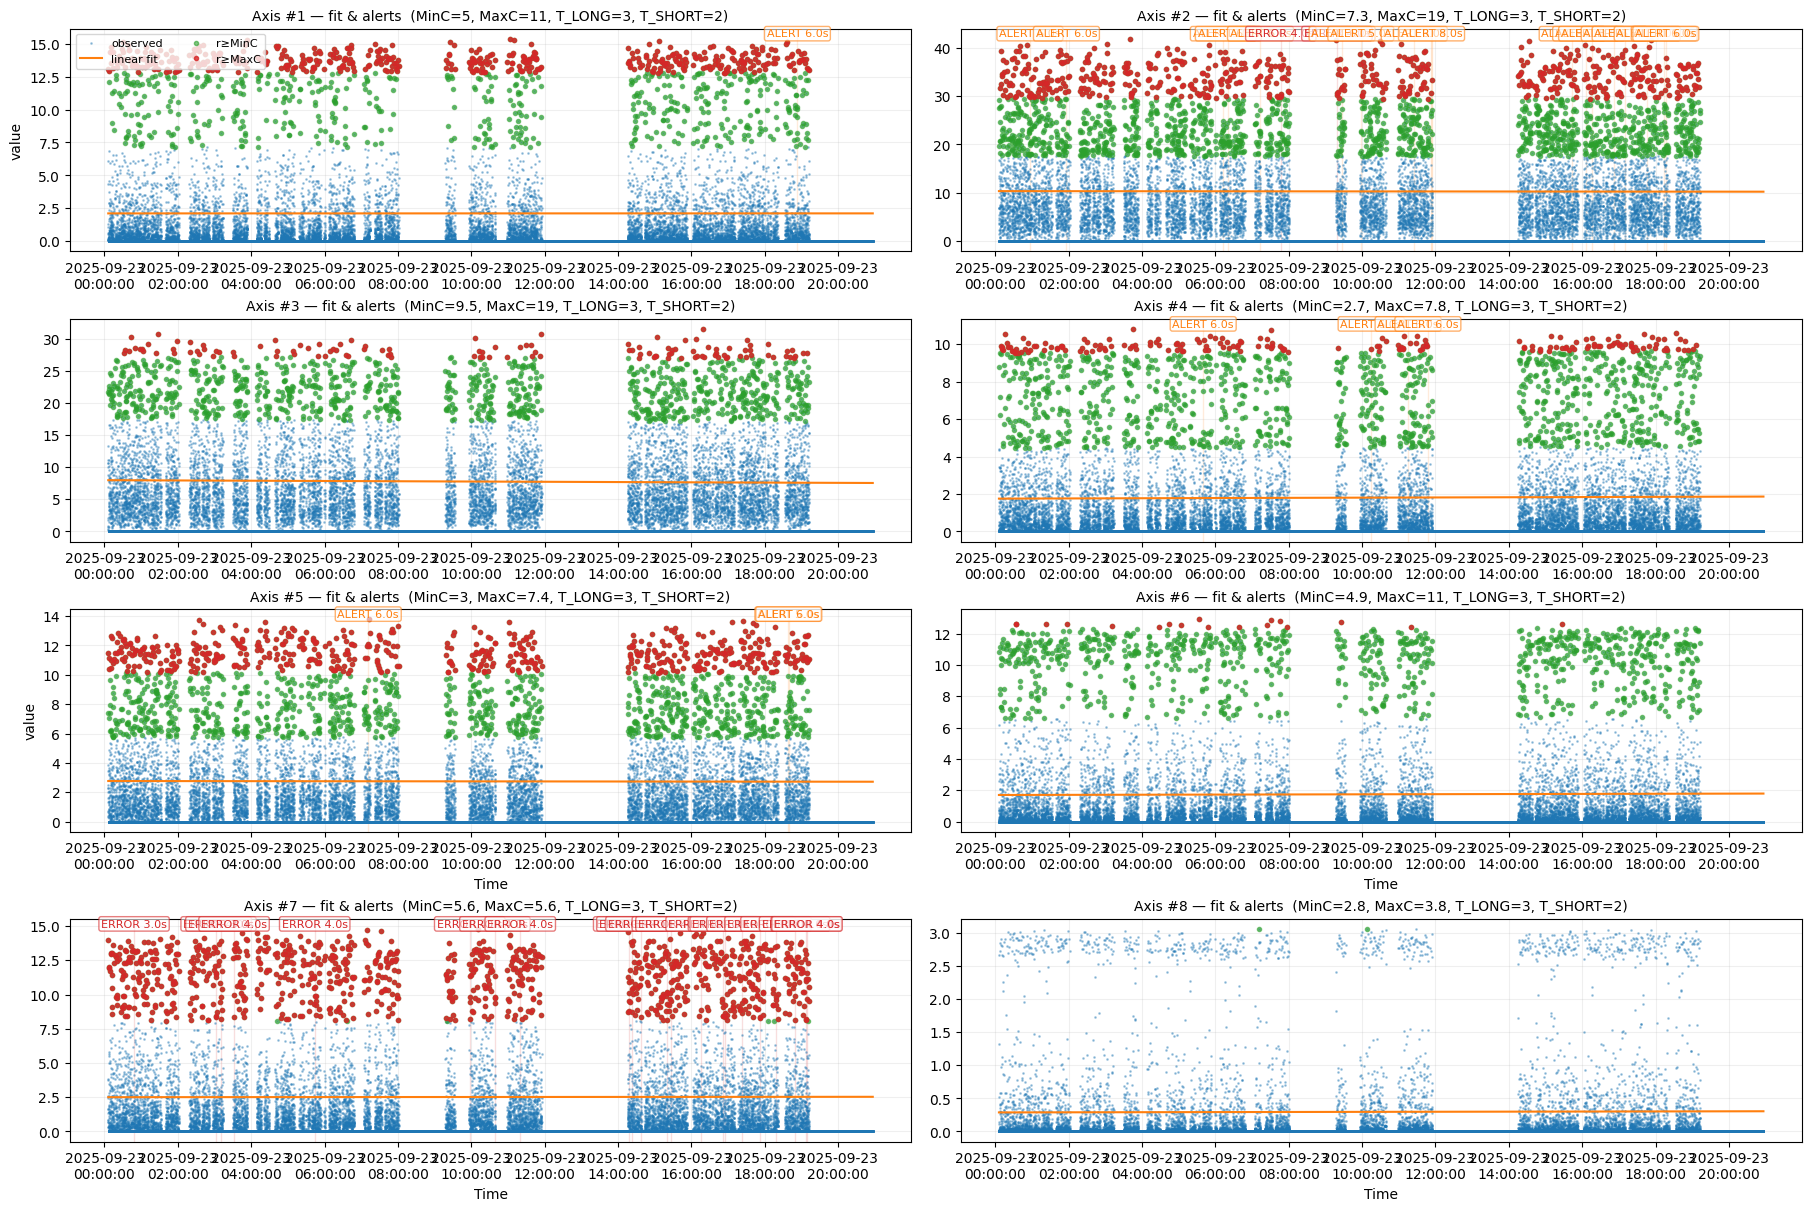

✅ Saved dashboard → C:\Users\jjh95\Desktop\Assignment\CSCN8010\Practical_Lab_1\data\offline_dashboard.png


In [96]:
# === DASH-1: Regression + Alert/Error annotations board (2×4) ===
import re, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

# --------- 0) Required artifacts check ---------
assert "models"   in globals() and isinstance(models, dict)   and len(models)>0,  "'models' is missing."
assert "th"       in globals() and isinstance(th, dict)       and len(th)>0,      "'th' is missing."
assert "T_counts" in globals() and isinstance(T_counts, dict) and len(T_counts)>0, "'T_counts' is missing."

# --------- 1) Load synthetic CSV & compute time_s ---------
SYN_PATH = max(Path("data").glob("RMBR4-2_export_synth_*.csv"), default=None)
assert SYN_PATH and SYN_PATH.exists(), "Could not find a synthetic CSV in the data/ folder."
df_syn = pd.read_csv(SYN_PATH)

# Find time column
time_candidates = [c for c in df_syn.columns if c.lower() in ("time","timestamp","datetime")]
assert time_candidates, "Missing Time/Timestamp column."
time_col = time_candidates[0]

def robust_time_to_seconds(series: pd.Series) -> pd.Series:
    trials = [
        dict(utc=False), dict(utc=True),
        dict(utc=False, infer_datetime_format=True), dict(utc=True, infer_datetime_format=True),
        dict(utc=False, format="%Y-%m-%dT%H:%M:%S"),
        dict(utc=True,  format="%Y-%m-%dT%H:%M:%S"),
        dict(utc=True,  format="%Y-%m-%dT%H:%M:%S.%fZ"),
        dict(utc=True,  format="%Y-%m-%dT%H:%M:%SZ"),
    ]
    for kw in trials:
        try:
            dt = pd.to_datetime(series, errors="coerce", **kw)
        except Exception:
            continue
        if dt.notna().sum()>0:
            t0 = dt.dropna().iloc[0]
            return (dt - t0).dt.total_seconds().astype(float), dt
    # numeric fallback
    s = series.astype(str).str.strip()
    s = s.str.replace(r"[^\d,.\-+eE]", "", regex=True)\
         .str.replace(r"(?<=\d),(?=\d{3}(\D|$))", "", regex=True)\
         .str.replace(",", ".", regex=False)
    x = pd.to_numeric(s, errors="coerce")
    assert x.notna().any(), "Failed to parse time."
    return (x - float(x.dropna().iloc[0])).astype(float), None

if "time_s" not in df_syn.columns:
    df_syn["time_s"], dt_series = robust_time_to_seconds(df_syn[time_col])
else:
    dt_series = None

# Whether to use datetime axis (two-line tick labels if available)
use_datetime = dt_series is not None and np.issubdtype(dt_series.dtype, np.datetime64)

if use_datetime:
    # ensure datetime dtype and build matplotlib date numbers
    dt_series = pd.to_datetime(dt_series, errors="coerce")
    x_num = mdates.date2num(dt_series.dt.to_pydatetime())

    # anchor (first timestamp) for converting seconds -> matplotlib date numbers
    dt0 = dt_series.iloc[0]

    def to_num(ts_sec: float) -> float:
        """seconds since t0 -> matplotlib date number"""
        return mdates.date2num(dt0 + pd.to_timedelta(ts_sec, unit="s"))
else:
    x_num = df_syn["time_s"].values.astype(float)

    def to_num(ts_sec: float) -> float:
        return float(ts_sec)

# Approx sample interval — for adjusting event start labels
dt_arr = np.diff(df_syn["time_s"].values.astype(float))
dt_arr = dt_arr[dt_arr>0]
median_dt = float(np.median(dt_arr)) if len(dt_arr) else 0.0

# --------- 2) Map CSV axes to artifact keys ---------
csv_axis_cols = [c for c in df_syn.columns if re.search(r"(axis|axes)\s*#?\s*(\d+)", str(c), re.I)]
assert csv_axis_cols, "Could not find Axis columns in the CSV."

def header_to_k(name:str):
    m = re.search(r"(axis|axes)\s*#?\s*(\d+)", name, re.I)
    return int(m.group(2)) if m else None

csv_axis_map = {c: header_to_k(c) for c in csv_axis_cols}
csv_axis_map = {c:k for c,k in csv_axis_map.items() if k is not None and 1 <= k <= 8}

def find_key_for_axis(d:dict, k:int):
    if k in d: return k
    pat = re.compile(rf"(?<!\d){k}(?!\d)")
    for key in d.keys():
        if key == f"Axis #{k}" or (isinstance(key,str) and pat.search(key)):
            return key
    return None

axes_plan = []
for col,k in sorted(csv_axis_map.items(), key=lambda x: x[1]):
    mkey = find_key_for_axis(models,k)
    thk  = find_key_for_axis(th,k)
    tk   = find_key_for_axis(T_counts,k)
    if None not in (mkey, thk, tk):
        axes_plan.append(dict(k=k, col=col, mkey=mkey, thk=thk, tk=tk))
assert axes_plan, "Axis mapping failed (check key names in models/th/T_counts)."

# --------- 3) Get events (compute on the fly if missing) ---------
def detect_events_batch(df, time_s, plan):
    events = []  # (axis, level, ts_start, ts_end, peak_dev)
    tvals = time_s.values
    dts = median_dt if median_dt>0 else (tvals[1]-tvals[0] if len(tvals)>1 else 0.0)
    for p in plan:
        k, col, mkey, thk, tk = p["k"], p["col"], p["mkey"], p["thk"], p["tk"]
        a = float(models[mkey].coef_[0]); b = float(models[mkey].intercept_)
        MinC = float(th[thk]["MinC"]);   MaxC = float(th[thk]["MaxC"])
        T_LONG  = int(T_counts[tk]["T_LONG_count"])
        T_SHORT = int(T_counts[tk]["T_SHORT_count"])
        open_level, ts_start, peak = None, None, 0.0
        cnt_min = cnt_max = 0
        yvals = pd.to_numeric(df[col], errors="coerce").fillna(0.0).values
        for ts, y in zip(tvals, yvals):
            yhat = a*ts + b
            dev  = max(0.0, y - yhat)
            if dev >= MaxC:
                cnt_max += 1; cnt_min = 0; level = "ERROR"
            elif dev >= MinC:
                cnt_min += 1; cnt_max = 0; level = "ALERT"
            else:
                if open_level is not None:
                    events.append((k, open_level, ts_start, ts, peak))
                open_level, ts_start, peak = None, None, 0.0
                cnt_min = cnt_max = 0
                continue
            if level == "ERROR":
                if open_level is None and cnt_max >= T_SHORT:
                    ts_start = ts - (T_SHORT-1)*dts; open_level = "ERROR"
                elif open_level == "ALERT":
                    open_level = "ERROR"
            else:
                if open_level is None and cnt_min >= T_LONG:
                    ts_start = ts - (T_LONG-1)*dts; open_level = "ALERT"
            peak = max(peak, dev)
        if open_level is not None:
            events.append((k, open_level, ts_start, tvals[-1], peak))
    return events

if "events" not in globals():
    events = detect_events_batch(df_syn, df_syn["time_s"], axes_plan)

# Events per axis dict
events_by_axis = {}
for (ax, lvl, t0, t1, peak) in events:
    events_by_axis.setdefault(ax, []).append((lvl, t0, t1, peak))

# --------- 4) Board plot ---------
fig, axs = plt.subplots(4, 2, figsize=(18, 12), constrained_layout=True)
axs = axs.ravel()

for i, p in enumerate(axes_plan[:8]):   # up to 8 axes
    ax = axs[i]
    k, col, mkey, thk, tk = p["k"], p["col"], p["mkey"], p["thk"], p["tk"]

    # Data / predictions
    y  = pd.to_numeric(df_syn[col], errors="coerce").fillna(0.0).values
    a  = float(models[mkey].coef_[0]); b = float(models[mkey].intercept_)
    yhat = a*df_syn["time_s"].values + b
    dev  = np.maximum(0.0, y - yhat)
    MinC = float(th[thk]["MinC"]);   MaxC = float(th[thk]["MaxC"])
    T_LONG  = int(T_counts[tk]["T_LONG_count"])
    T_SHORT = int(T_counts[tk]["T_SHORT_count"])

    # Base lines
    if use_datetime:
        ax.plot_date(x_num, y, fmt=".", alpha=0.35, ms=2, label="observed")
        ax.plot_date(x_num, yhat, fmt="-", lw=1.5, label="linear fit")
    else:
        ax.plot(df_syn["time_s"], y, ".", alpha=0.35, ms=2, label="observed")
        ax.plot(df_syn["time_s"], yhat, "-", lw=1.5, label="linear fit")

    # Highlight points exceeding thresholds
    mask_min = dev >= MinC
    mask_max = dev >= MaxC
    if use_datetime:
        ax.plot_date(x_num[mask_min], y[mask_min], "o", ms=3, alpha=0.6, label="r≥MinC")
        ax.plot_date(x_num[mask_max], y[mask_max], "o", ms=3, alpha=0.8, label="r≥MaxC")
    else:
        ax.plot(df_syn["time_s"][mask_min], y[mask_min], "o", ms=3, alpha=0.6, label="r≥MinC")
        ax.plot(df_syn["time_s"][mask_max], y[mask_max], "o", ms=3, alpha=0.8, label="r≥MaxC")

    # Event bands (duration labels)
    for (lvl, t0, t1, peak) in events_by_axis.get(k, []):
        x0 = to_num(t0)
        x1 = to_num(t1)
        color = "tab:orange" if lvl == "ALERT" else "tab:red"
        ax.axvspan(x0, x1, color=color, alpha=0.15)

        mid = (x0 + x1) / 2.0
        ax.text(mid, ax.get_ylim()[1], f"{lvl} {t1 - t0:.1f}s",
            ha="center", va="top", fontsize=8, color=color,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color, alpha=0.6))

    # Title / axis labels
    ax.set_title(f"Axis #{k} — fit & alerts  (MinC={MinC:.2g}, MaxC={MaxC:.2g}, "
                 f"T_LONG={T_LONG}, T_SHORT={T_SHORT})", fontsize=10)
    if use_datetime:
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M:%S"))
    if i % 4 == 0:
        ax.set_ylabel("value")
    if i >= 4:
        ax.set_xlabel("Time" if use_datetime else "time_s (sec)")
    ax.grid(alpha=0.2)
    if i == 0:
        ax.legend(loc="upper left", fontsize=8, ncol=2)

# Turn off unused axes
for j in range(i+1, len(axs)):
    axs[j].axis("off")

out_path = Path("data/offline_dashboard.png")
plt.savefig(out_path, dpi=150)
plt.show()
print(f"✅ Saved dashboard → {out_path.resolve()}")